<div style="background-color:#00000">
    <img src="https://fundacionsadosky.org.ar/wp-content/uploads/2022/08/logo.png" />
</div>
<div style="background-color:#03030a; margin:20px 40%">
    <img src="https://www.rfindustrial.com/wp-content/uploads/2023/04/cropped-1080x1080_Mesa-de-trabajo-1.png" />
</div>
<div style="background-color:#00000;">
    <img src="https://sinc.unl.edu.ar/wp-content/themes/sinci/img/sinc-logo.png" />
</div>

<p style="font-size: 30px">
    <strong>COPE - “Sistema inteligente de medición de nivel y control de velocidad de bombeo para pozos petrolíferos"</strong>
</p>

<p style="font-size: 20px">
    Objetivo del análisis: Realizar un primer acercamiento a los datos para comprender su estructura, valores comúnes, características principales de las señales, entre otros.
</p>

04/08/2023

# Imports generales

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import signal
import struct
import matplotlib.pyplot as plt
from ipywidgets import interact_manual, widgets

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Exploración de archivos para uno de los equipos

In [2]:
!tree '../data/raw/20_10_2021 ( pruebas tiro cuplas largo)/8'

/Library/Developer/CommandLineTools/usr/bin/python3: No module named virtualfish
../data/raw/20_10_2021\ (\ pruebas\ tiro\ cuplas\ largo)/8
├── Cont
├── Program.json
├── ProgramCouter
├── _10_22_23_46_02__Frec1(351)_IncF(20)_Nciclos(8)_SwIn(1)_Down(32)_Nsamp)16000)
│   ├── _Eco_23_46_02.json
│   └── _Eco_23_46_48.json
├── _10_22_23_47_09__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)
│   ├── _Eco_23_47_09.json
│   ├── _Eco_23_47_30.json
│   ├── _Eco_23_47_50.json
│   ├── _Eco_23_48_11.json
│   ├── _Eco_23_48_32.json
│   ├── _Eco_23_48_53.json
│   ├── _Eco_23_49_13.json
│   ├── _Eco_23_49_34.json
│   ├── _Eco_23_50_09.json
│   └── _Eco_23_50_30.json_wrong
├── _10_22_23_51_04__Frec1(351)_IncF(20)_Nciclos(8)_SwIn(1)_Down(32)_Nsamp)16000)
│   ├── _Eco_23_51_04.json
│   ├── _Eco_23_51_50.json
│   ├── _Eco_23_52_37.json
│   ├── _Eco_23_53_25.json
│   └── _Eco_23_56_46.json
├── _10_23_00_01_16__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)
│   ├── _Eco_00_01_16.jso

# Definición de funciones útiles

In [3]:
def load_sample_file(sample_full_path):
    df = pd.read_json(sample_full_path, typ='series')
    
    final_values = []
    
    data_values = df.datos
    data_values = data_values.strip("[]").split(",")
    
    for value in data_values:
        # Convierte el valor hexadecimal a un entero sin signo de 32 bits
        value = int(value, 16) & 0xFFFFFFFF
        
        # Verifica si el bit más significativo es 1 para determinar si el valor está en complemento a uno
        if value & 0x80000000:
            # Si el bit más significativo es 1, convierte el valor a su complemento a dos
            value = -(0x100000000 - value)

        # Agrega el valor a la lista de enteros
        final_values.append(value)
    
    return df, final_values

In [4]:
def get_input_signal(initial_freq, signal_step, freq_step, n_cycles):
    with open('tabla_seno.bin', 'rb') as file:
        bytes = file.read()
        sine_values = struct.unpack('{}H'.format(len(bytes) // 2), bytes)
    
    # Se crea una lista vacía que se llenará con los valores de la señal muestreada
    signal_values = []
    cycles_info = []

    # Se inicializan las variables de iteración
    inter = 0
    freq = initial_freq
    step = signal_step // 32
    
    last_cycle_inter = 0
    
    # Se ejecuta un ciclo para generar la señal senoidal
    for i in range(n_cycles):
        j = 0
        # Se recorre la tabla de valores precalculados de la función seno
        while j < len(sine_values):
            # Se verifica si se debe tomar una muestra en este punto
            if inter % step == 0:
                # Se obtiene el valor de la función seno en este punto
                y = sine_values[j]
                # Se agrega el valor de la muestra a la lista
                signal_values.append(y)
            # Se avanza al siguiente punto de la señal
            j += freq
            # Se incrementa el índice que se utiliza para verificar si se debe tomar una muestra
            inter += 1
        # Se recorre la tabla de valores precalculados de la función seno en sentido inverso
        while j < 2 * len(sine_values):
            # Se verifica si se debe tomar una muestra en este punto
            if inter % step == 0:
                # Se obtiene el valor de la función seno en este punto y se invierte su signo
                y = -sine_values[j - len(sine_values)]
                # Se agrega el valor de la muestra a la lista
                signal_values.append(y)
            # Se avanza al siguiente punto de la señal
            j += freq
            # Se incrementa el índice que se utiliza para verificar si se debe tomar una muestra
            inter += 1
        # Se ajusta el índice para reiniciar la generación de la señal en la tabla de valores
        j -= 2 * len(sine_values)
        
        cycles_info.append((inter - last_cycle_inter, freq))
        last_cycle_inter = inter
    
                           
        # Se incrementa la frecuencia de la señal para el siguiente ciclo
        freq += freq_step
    
    return signal_values, cycles_info

# Explicación de cómo se genera el pulso de entrada

A partir de una lista de números (la cual se grafica a continuación), lo que se hace por cada ciclo es ir leyendo los valores de dicho array incrementando la posición de lectura tantas posiciones como sea la frecuencia inicial (por ejemplo 301). Por cada ciclo se leen los valores de forma incremental hasta tanto el índice llegue al final del array, y luego se comienza a leer nuevamente de adelante hacia atrás de la misma manera pero tomando el valor de lectura como negativo.

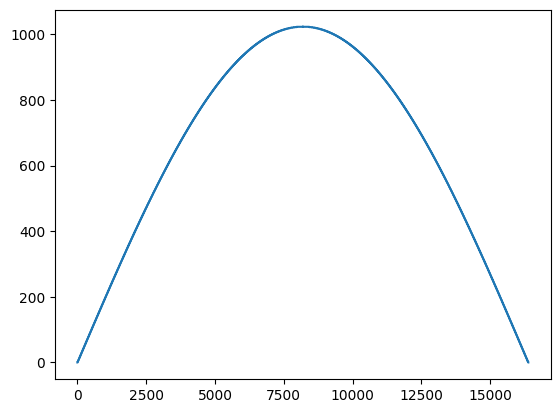

In [5]:
with open('tabla_seno.bin', 'rb') as file:
    bytes = file.read()
    sine_values = struct.unpack('{}H'.format(len(bytes) // 2), bytes)

t = list(range(len(sine_values)))
s = sine_values

plt.plot(t, s)

# Determinación del ejemplo a utilizar

In [6]:
id_equipo = 8
path = '_10_22_23_47_09__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)'
file = '_Eco_23_47_09.json'
full_path = f'../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/{id_equipo}/{path}/{file}'

df, final_values = load_sample_file(full_path)

df

Id                                                         8
Frec1                                                      7
IncF                                                       1
Nciclos                                                   15
Aten                                                       0
SwIn                                                       1
Filter                                                     5
Down                                                    1024
Dummy                                                      0
Nsamp                                                   6000
datos      [F3BB5550,00009FDA,000DF7A6,FF74063E,0238ED0C,...
dtype: object

In [7]:
signal_values, cycles_info = get_input_signal(df.Frec1, df.Down, df.IncF, df.Nciclos)

In [8]:
cycles_info

[(4681, 7),
 (4096, 8),
 (3641, 9),
 (3277, 10),
 (2979, 11),
 (2731, 12),
 (2521, 13),
 (2341, 14),
 (2185, 15),
 (2048, 16),
 (1928, 17),
 (1821, 18),
 (1725, 19),
 (1639, 20),
 (1561, 21)]

In [9]:
x_values = []
last_cycle_value = 0
for n_cycle in range(df.Nciclos):
    x_values += list(np.linspace(last_cycle_value, last_cycle_value + 1 / cycles_info[n_cycle][1], cycles_info[n_cycle][0])[::32])
    last_cycle_value = x_values[-1] + (x_values[-1] - x_values[-2])

## Visualización del pulso de entrada

In [10]:
cycles_info

[(4681, 7),
 (4096, 8),
 (3641, 9),
 (3277, 10),
 (2979, 11),
 (2731, 12),
 (2521, 13),
 (2341, 14),
 (2185, 15),
 (2048, 16),
 (1928, 17),
 (1821, 18),
 (1725, 19),
 (1639, 20),
 (1561, 21)]

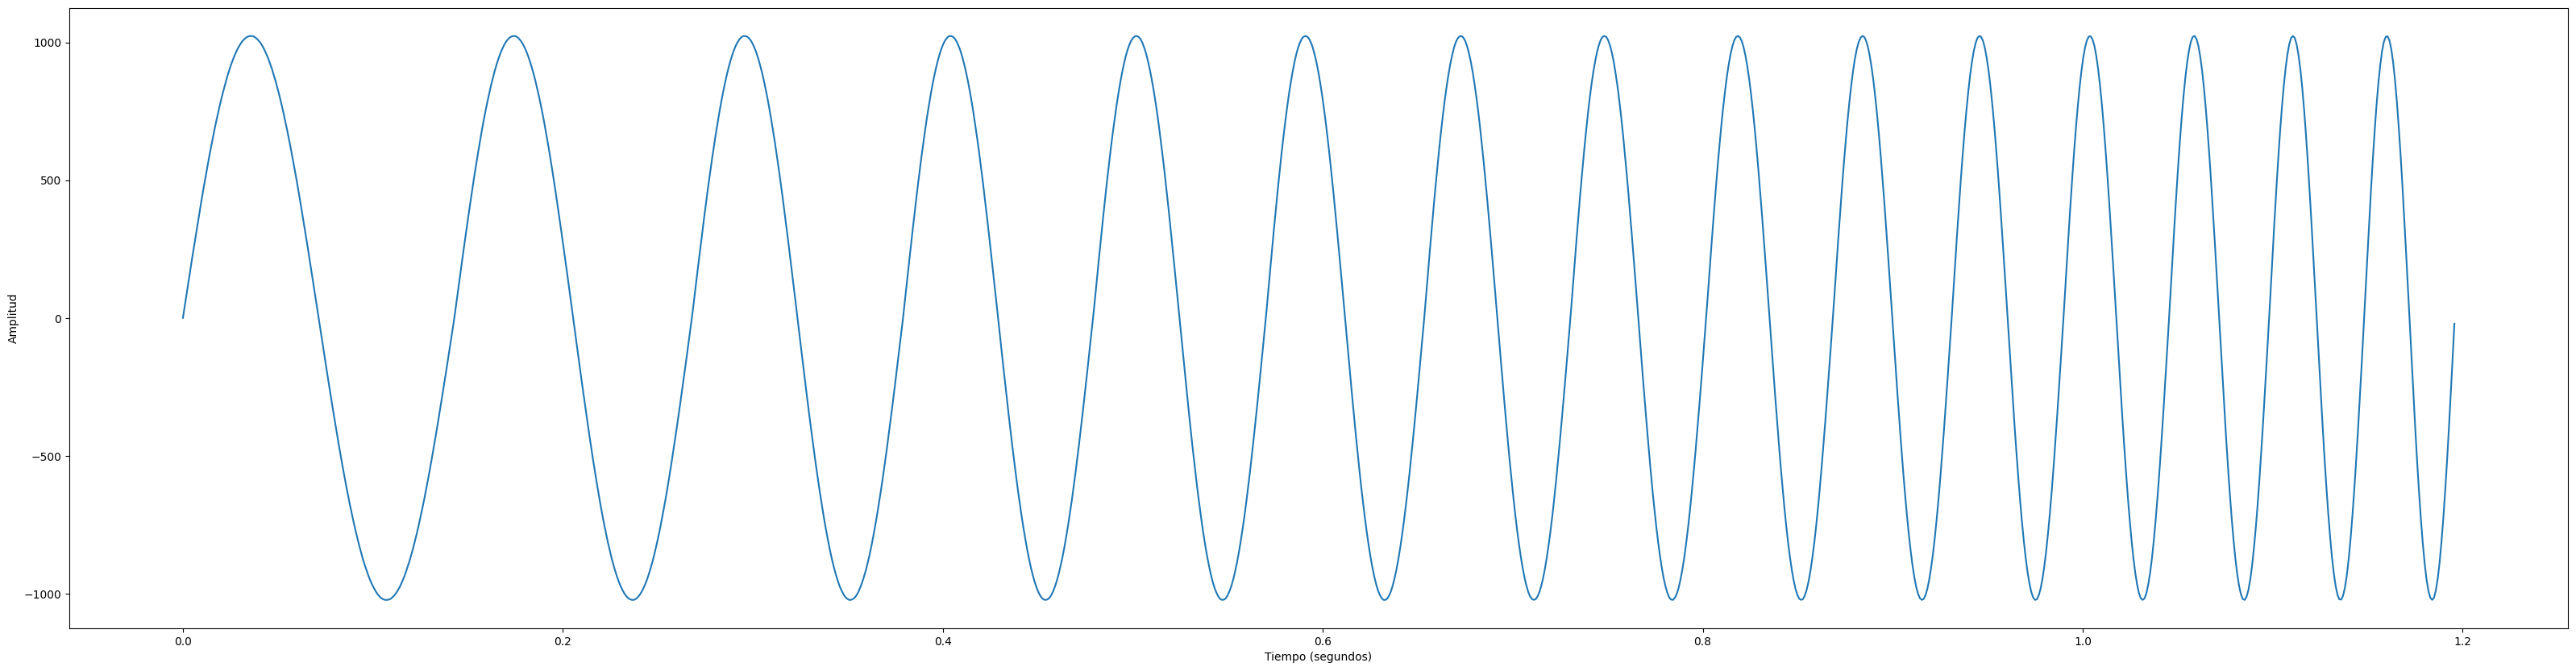

In [11]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(x_values[:1225], signal_values) # agregar datos a la gráfica
#ax.set_xlim([0, len(signal_values)]) # establecer límites del eje x
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.show()

## Visualización de señal de salida

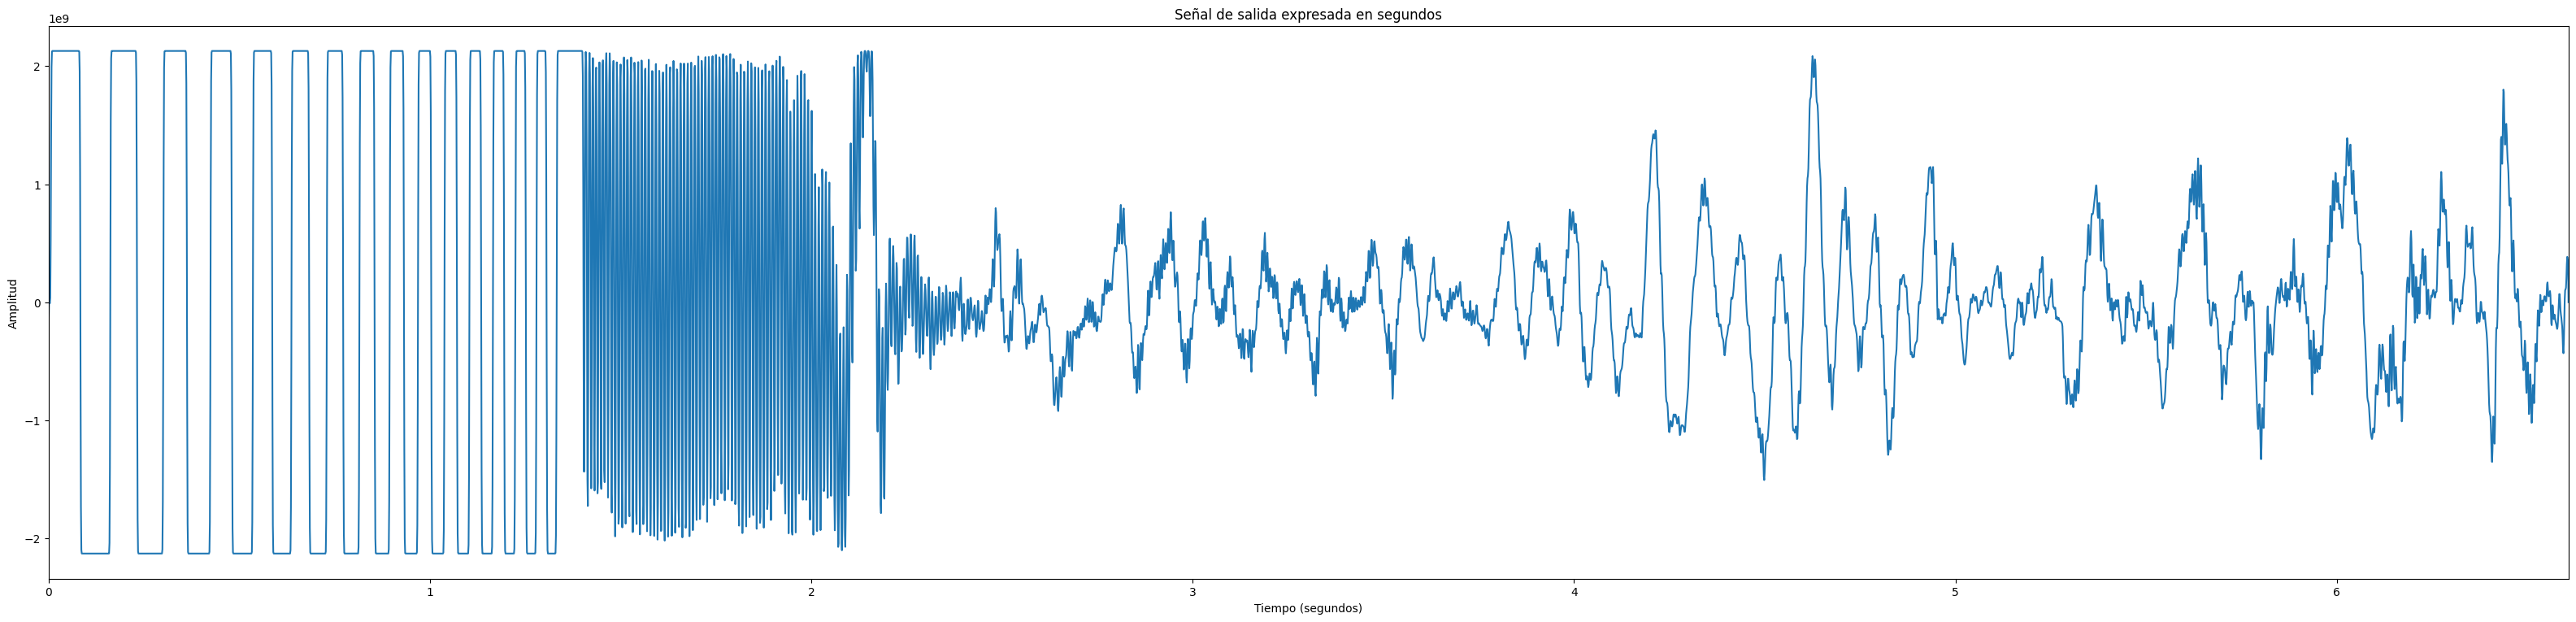

In [12]:
final_signal_freq = 930000 / df.Down
x_values = np.linspace(0, len(final_values) / final_signal_freq, len(final_values))

# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
fig.subplots_adjust(bottom=0.2)
ax.set_xlim([0, x_values[-1]]) # establecer límites del eje x
ax.plot(x_values, final_values) # agregar datos a la gráfica
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.title('Señal de salida expresada en segundos')
plt.show()

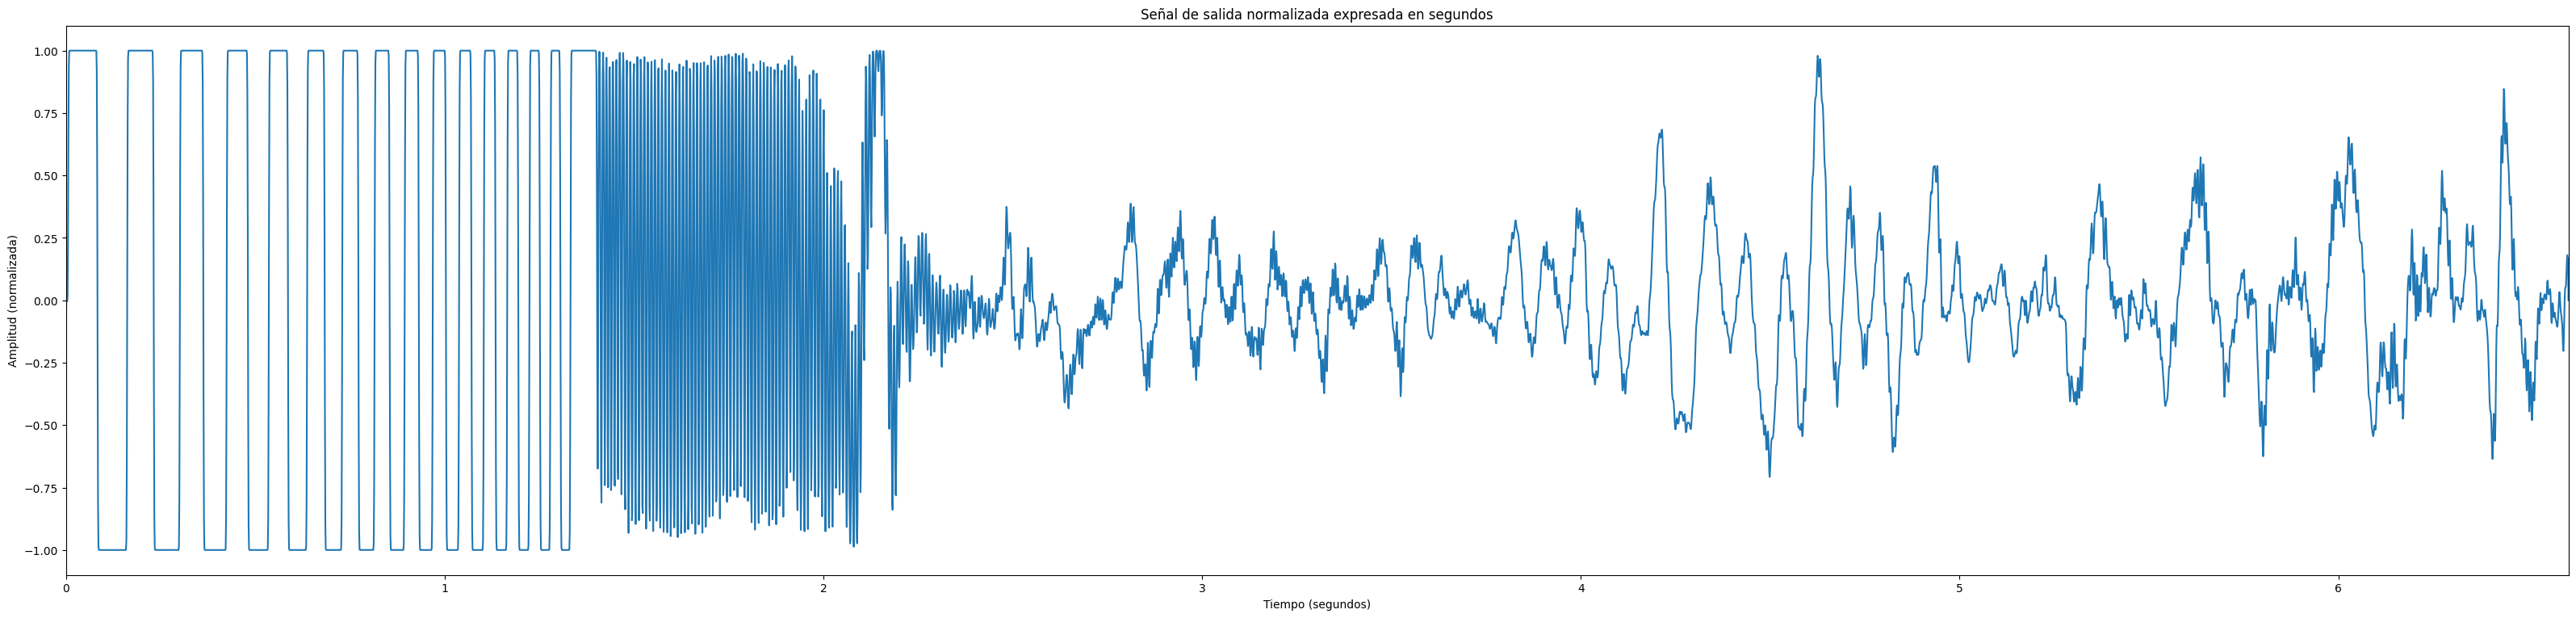

In [13]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
fig.subplots_adjust(bottom=0.2)
ax.set_xlim([0, x_values[-1]]) # establecer límites del eje x
final_values_norm = final_values / np.max(np.abs(final_values))
ax.plot(x_values, final_values_norm) # agregar datos a la gráfica
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud (normalizada)')
plt.title('Señal de salida normalizada expresada en segundos')
plt.show()

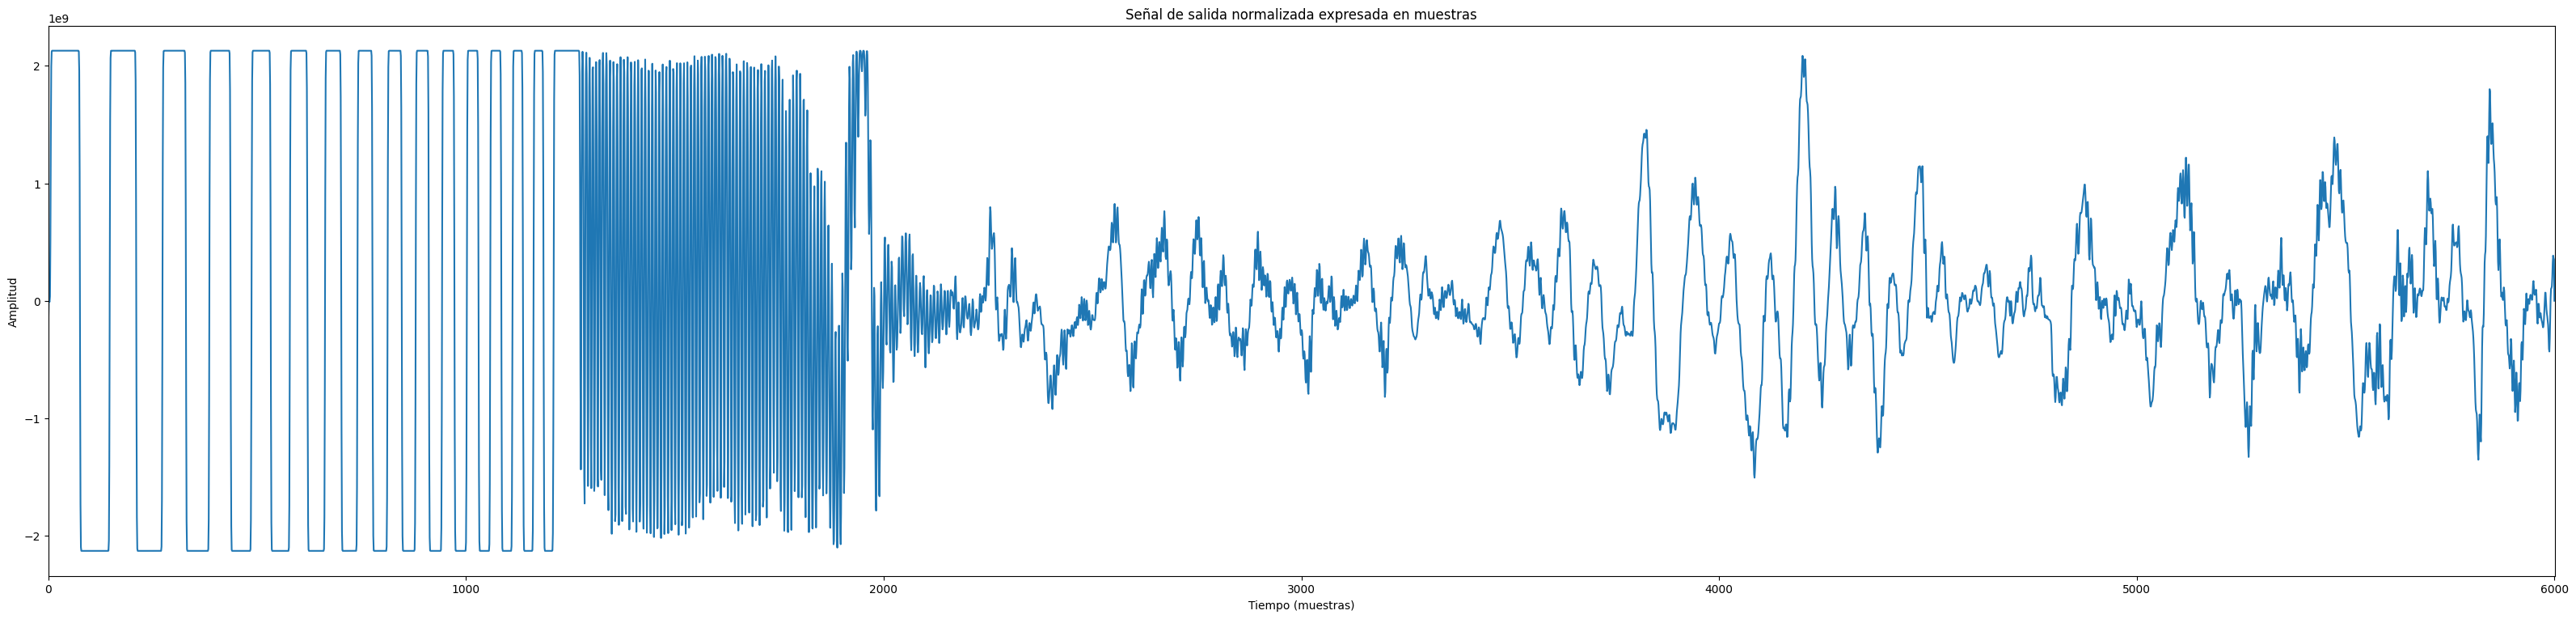

In [14]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
fig.subplots_adjust(bottom=0.2)
ax.set_xlim([0, len(final_values)]) # establecer límites del eje x
ax.plot(final_values) # agregar datos a la gráfica
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.title('Señal de salida normalizada expresada en muestras')
plt.show()

## Visualización de un espectrograma para un tamaño de ventana y solapamiento determinado

In [15]:
# Nivel de fluído estimado: 770,93 m
# distancia necesaria de recorrido del disparo: 1.541,86 m
# velocidad promedio del sonido en el medio: 401 m/s
# Tiempo aproximado de llegada del eco: 1.541,86 / 401 = 3,845 s

In [16]:
final_signal_freq

908.203125

In [17]:
nfft_w = widgets.IntText(
    value=32,
    description='NFFT:',
    disabled=False
)

noverlap_w = widgets.IntText(
    value=8,
    description='No overlap:',
    disabled=False
)

@interact_manual(nfft=nfft_w, noverlap=noverlap_w)
def plot_specgram(nfft, noverlap):
    fig, ax = plt.subplots(figsize=(20, 10))
    Pxx, freqs, bins, im = ax.specgram(final_values_norm,
                                       NFFT=nfft,
                                       Fs=final_signal_freq,
                                       noverlap=noverlap,
                                       cmap=plt.get_cmap('plasma'))

    #plt.axis([0, 0.1, 0, 2000])

    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Frecuencia (Hz)')
    
    plt.title(f'Espectrograma utilizando una ventana de {nfft} muestras y una superposición de {noverlap}.')
    plt.show()

interactive(children=(IntText(value=32, description='NFFT:'), IntText(value=8, description='No overlap:'), But…

# Filtrado de la señal

In [18]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=6):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [19]:
final_values_filtered = butter_bandpass_filter(final_values_norm, 5, 25, final_signal_freq, order=4)

In [20]:
def plot_specgram_static(values, nfft, noverlap):
    fig, ax = plt.subplots(figsize=(20, 10))
    Pxx, freqs, bins, im = ax.specgram(values,
                                       NFFT=nfft,
                                       Fs=final_signal_freq,
                                       noverlap=noverlap,
                                       cmap=plt.get_cmap('plasma'))

    #plt.axis([0, 0.1, 0, 2000])

    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Frecuencia (Hz)')
    
    plt.title(f'Espectrograma utilizando una ventana de {nfft} muestras y una superposición de {noverlap}.')
    plt.show()

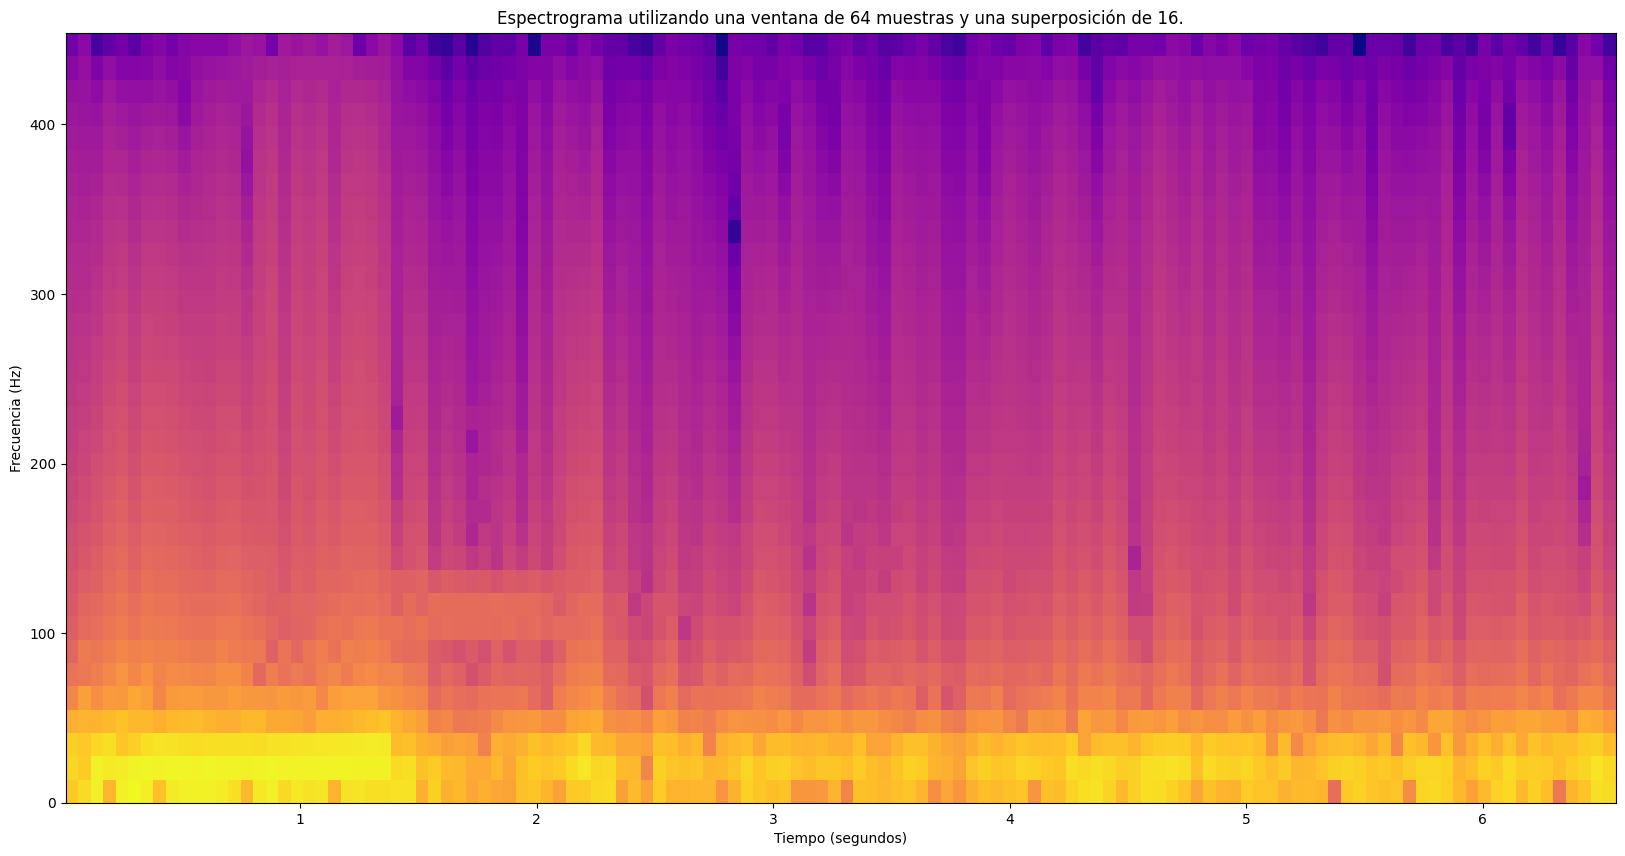

In [21]:
plot_specgram_static(final_values_filtered, 64, 16)

# Se repite el proceso usando el promedio de distintas ecometrías

In [22]:
id_equipo = 8
path = '_10_22_23_47_09__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)'
full_path = f'../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/{id_equipo}/{path}/'

input_files = glob(full_path + '/*.json')

print(input_files)

files_values = []

for file in input_files:
    df, file_values = load_sample_file(file)
    if len(file_values) >= 6000:
        files_values.append(file_values / np.max(np.abs(file_values)))

sum_files_values_norm = np.sum(files_values, axis=0)

['../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/8/_10_22_23_47_09__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)/_Eco_23_47_09.json', '../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/8/_10_22_23_47_09__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)/_Eco_23_50_30.json', '../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/8/_10_22_23_47_09__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)/_Eco_23_48_11.json', '../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/8/_10_22_23_47_09__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)/_Eco_23_48_53.json', '../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/8/_10_22_23_47_09__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)/_Eco_23_50_09.json', '../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/8/_10_22_23_47_09__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)/_Eco_23_49_13.json', '../data/raw/ec

In [23]:
final_signal_freq = 930000 / df.Down

In [24]:
nfft_w = widgets.IntText(
    value=32,
    description='NFFT:',
    disabled=False
)

noverlap_w = widgets.IntText(
    value=8,
    description='No overlap:',
    disabled=False
)

@interact_manual(nfft=nfft_w, noverlap=noverlap_w)
def plot_specgram(nfft, noverlap):
    fig, ax = plt.subplots(figsize=(20, 10))
    Pxx, freqs, bins, im = ax.specgram(sum_files_values_norm,
                                       NFFT=nfft,
                                       Fs=final_signal_freq,
                                       noverlap=noverlap,
                                       cmap=plt.get_cmap('plasma'))

    #plt.axis([0, 0.1, 0, 2000])

    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Frecuencia (Hz)')
    
    plt.title(f'Espectrograma utilizando una ventana de {nfft} muestras y una superposición de {noverlap} sobre el promedio de diferentes disparos.')
    plt.show()

interactive(children=(IntText(value=32, description='NFFT:'), IntText(value=8, description='No overlap:'), But…

# Correlation

Get accumulated output signals

In [25]:
sum_files_values_norm

array([-0.15608012, -0.00839726, -0.16108501, ...,  0.03245013,
       -0.08343703,  0.        ])

Get input signal

In [26]:
signal_values, cycles_info = get_input_signal(df.Frec1, df.Down, df.IncF, df.Nciclos)

Calculate correlation

In [27]:
corr = signal.correlate(sum_files_values_norm, signal_values)

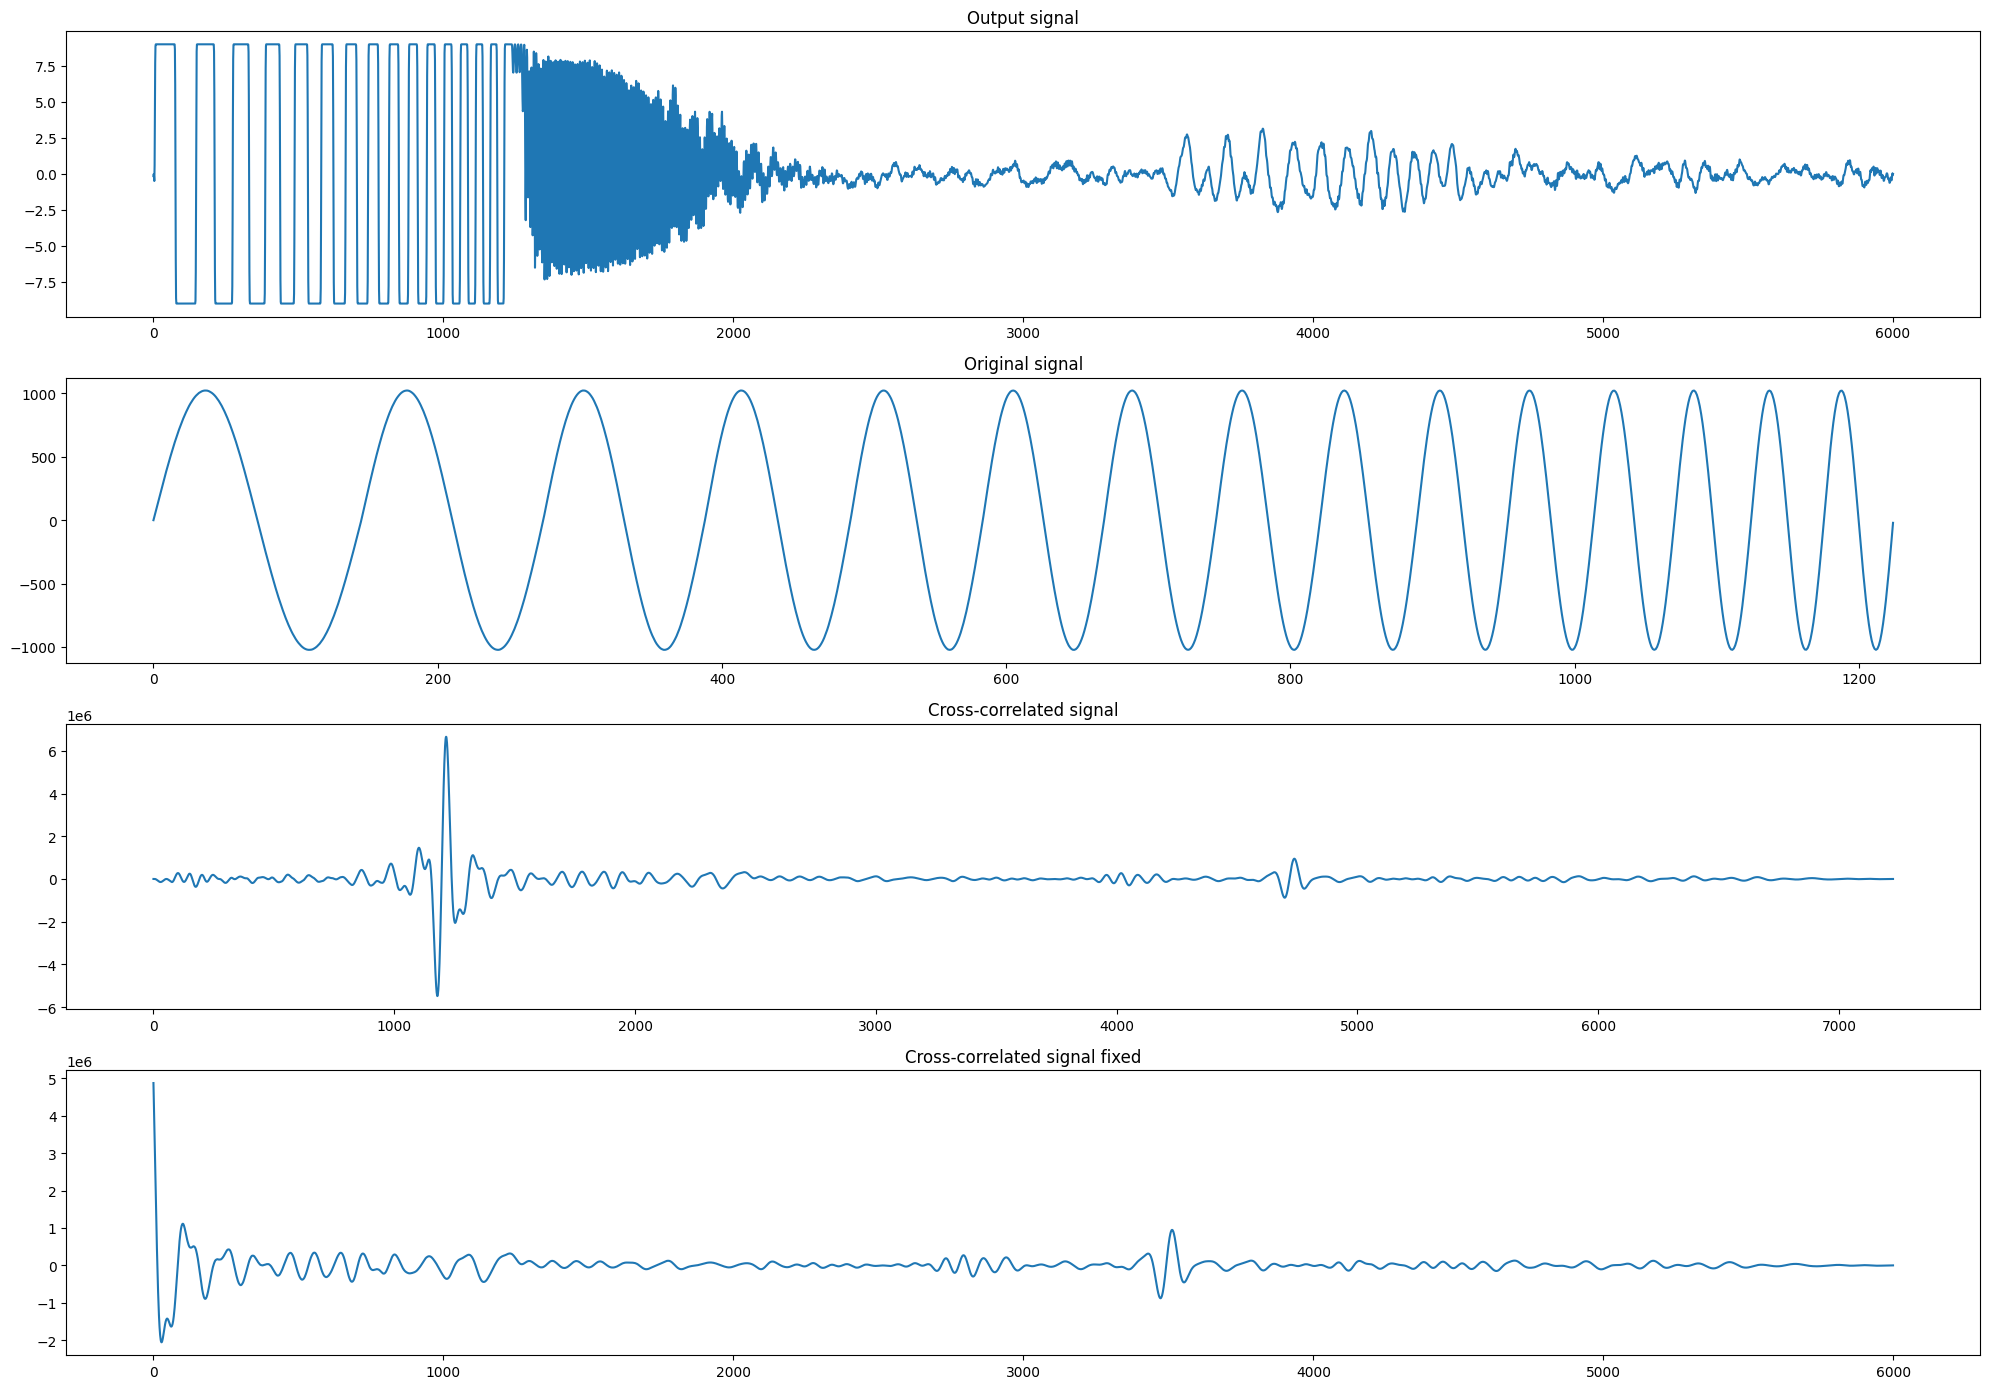

In [28]:
fig, (ax_output, ax_input, ax_corr, ax_corr_fixed) = plt.subplots(4, 1, figsize=(20, 14))
ax_output.plot(sum_files_values_norm)
ax_output.set_title('Output signal')
#ax_noise.set_xlabel('Sample Number')
ax_input.plot(signal_values)
ax_input.set_title('Original signal')
#ax_orig.set_xlabel('Sample Number')
ax_corr.plot(corr)
ax_corr.set_title('Cross-correlated signal')

corr_fixed = corr[len(signal_values):]
ax_corr_fixed.plot(corr_fixed)
ax_corr_fixed.set_title('Cross-correlated signal fixed')
#ax_corr.set_xlabel('Lag')
#ax_orig.margins(0, 0.1)
#ax_noise.margins(0, 0.1)
#ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [29]:
index_remove = 2000
max_position = np.argmax(corr_fixed[index_remove:]) + index_remove
print('Índice del valor más grande: ', max_position)

Índice del valor más grande:  3513


In [30]:
eco_elapsed_time = max_position / final_signal_freq / 2
print('Tiempo estimado de recorrido de la señal: ', eco_elapsed_time)

print('Profundidad estimada:', eco_elapsed_time * 397)

Tiempo estimado de recorrido de la señal:  1.9340387096774194
Profundidad estimada: 767.8133677419355


El valor de verdad para este pozo es de 770,93.

# Se repite para otros pozos

In [31]:
def get_values_for_path(path):
    input_files = glob(full_path + '/*.json')

    print('Número de ecometrias:',  len(input_files))
    files_values = []

    for file in input_files:
        df, file_values = load_sample_file(file)

        if (len(files_values) > 0 and len(file_values) == len(files_values[0])) or len(files_values) == 0:
            files_values.append(file_values / np.max(np.abs(file_values)))
        else:
            print(f'Ecometría con cantidad de valores distintos ({len(file_values)}): ', file)

    sum_files_values_norm = np.sum(files_values, axis=0)
    
    signal_values, cycles_info = get_input_signal(df.Frec1, df.Down, df.IncF, df.Nciclos)
    
    corr = signal.correlate(sum_files_values_norm, signal_values)
    
    # Generate plots
    fig, (ax_output, ax_input, ax_corr, ax_corr_fixed) = plt.subplots(4, 1, figsize=(20, 14))
    ax_output.plot(sum_files_values_norm)
    ax_output.set_title('Señal capturada')
    ax_input.plot(signal_values)
    ax_input.set_title('Impulso de entrada')
    ax_corr.plot(corr)
    ax_corr.set_title('Resultado correlación')

    corr_fixed = corr[len(signal_values):]
    ax_corr_fixed.plot(corr_fixed)
    ax_corr_fixed.set_title('Resultado correlación corregido')
    fig.tight_layout()
    plt.show()
    
    index_remove = 2000
    max_position = np.argmax(corr_fixed[index_remove:]) + index_remove
    print('Índice del valor más grande: ', max_position)
    
    eco_elapsed_time = max_position / final_signal_freq / 2
    print('Tiempo estimado de recorrido de la señal: ', eco_elapsed_time)

    print('Profundidad estimada:', eco_elapsed_time * 397)

Número de ecometrias: 2
Ecometría con cantidad de valores distintos (1544):  ../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/8/_10_23_00_01_16__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)/_Eco_00_01_16.json


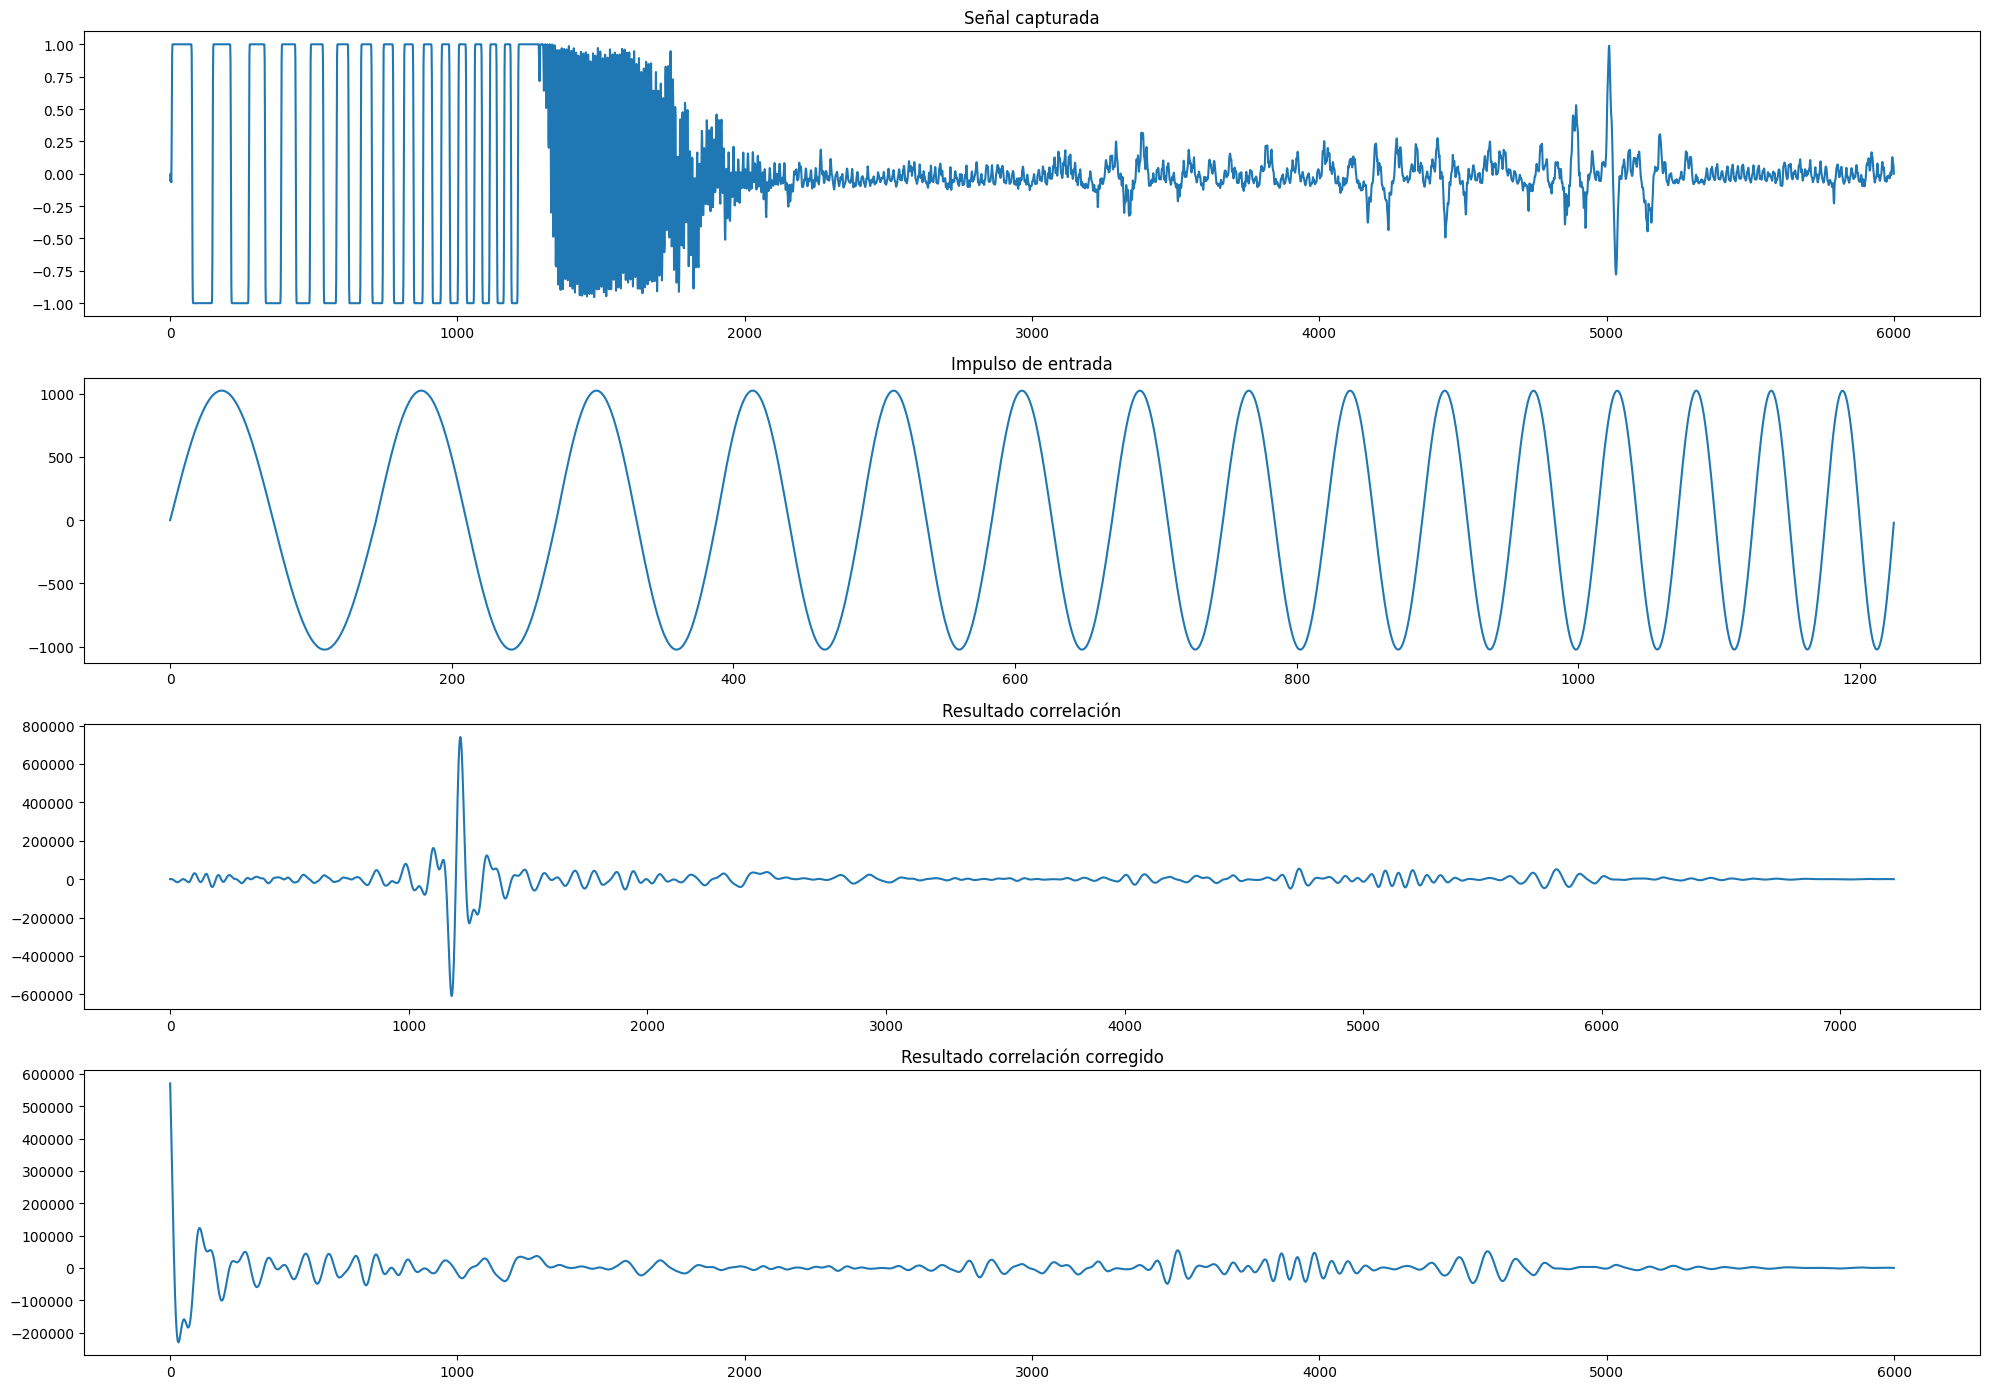

Índice del valor más grande:  3507
Tiempo estimado de recorrido de la señal:  1.9307354838709678
Profundidad estimada: 766.5019870967742


In [32]:
id_equipo = 8
path = '_10_23_00_01_16__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)'
full_path = f'../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/{id_equipo}/{path}/'

get_values_for_path(full_path)

Número de ecometrias: 3


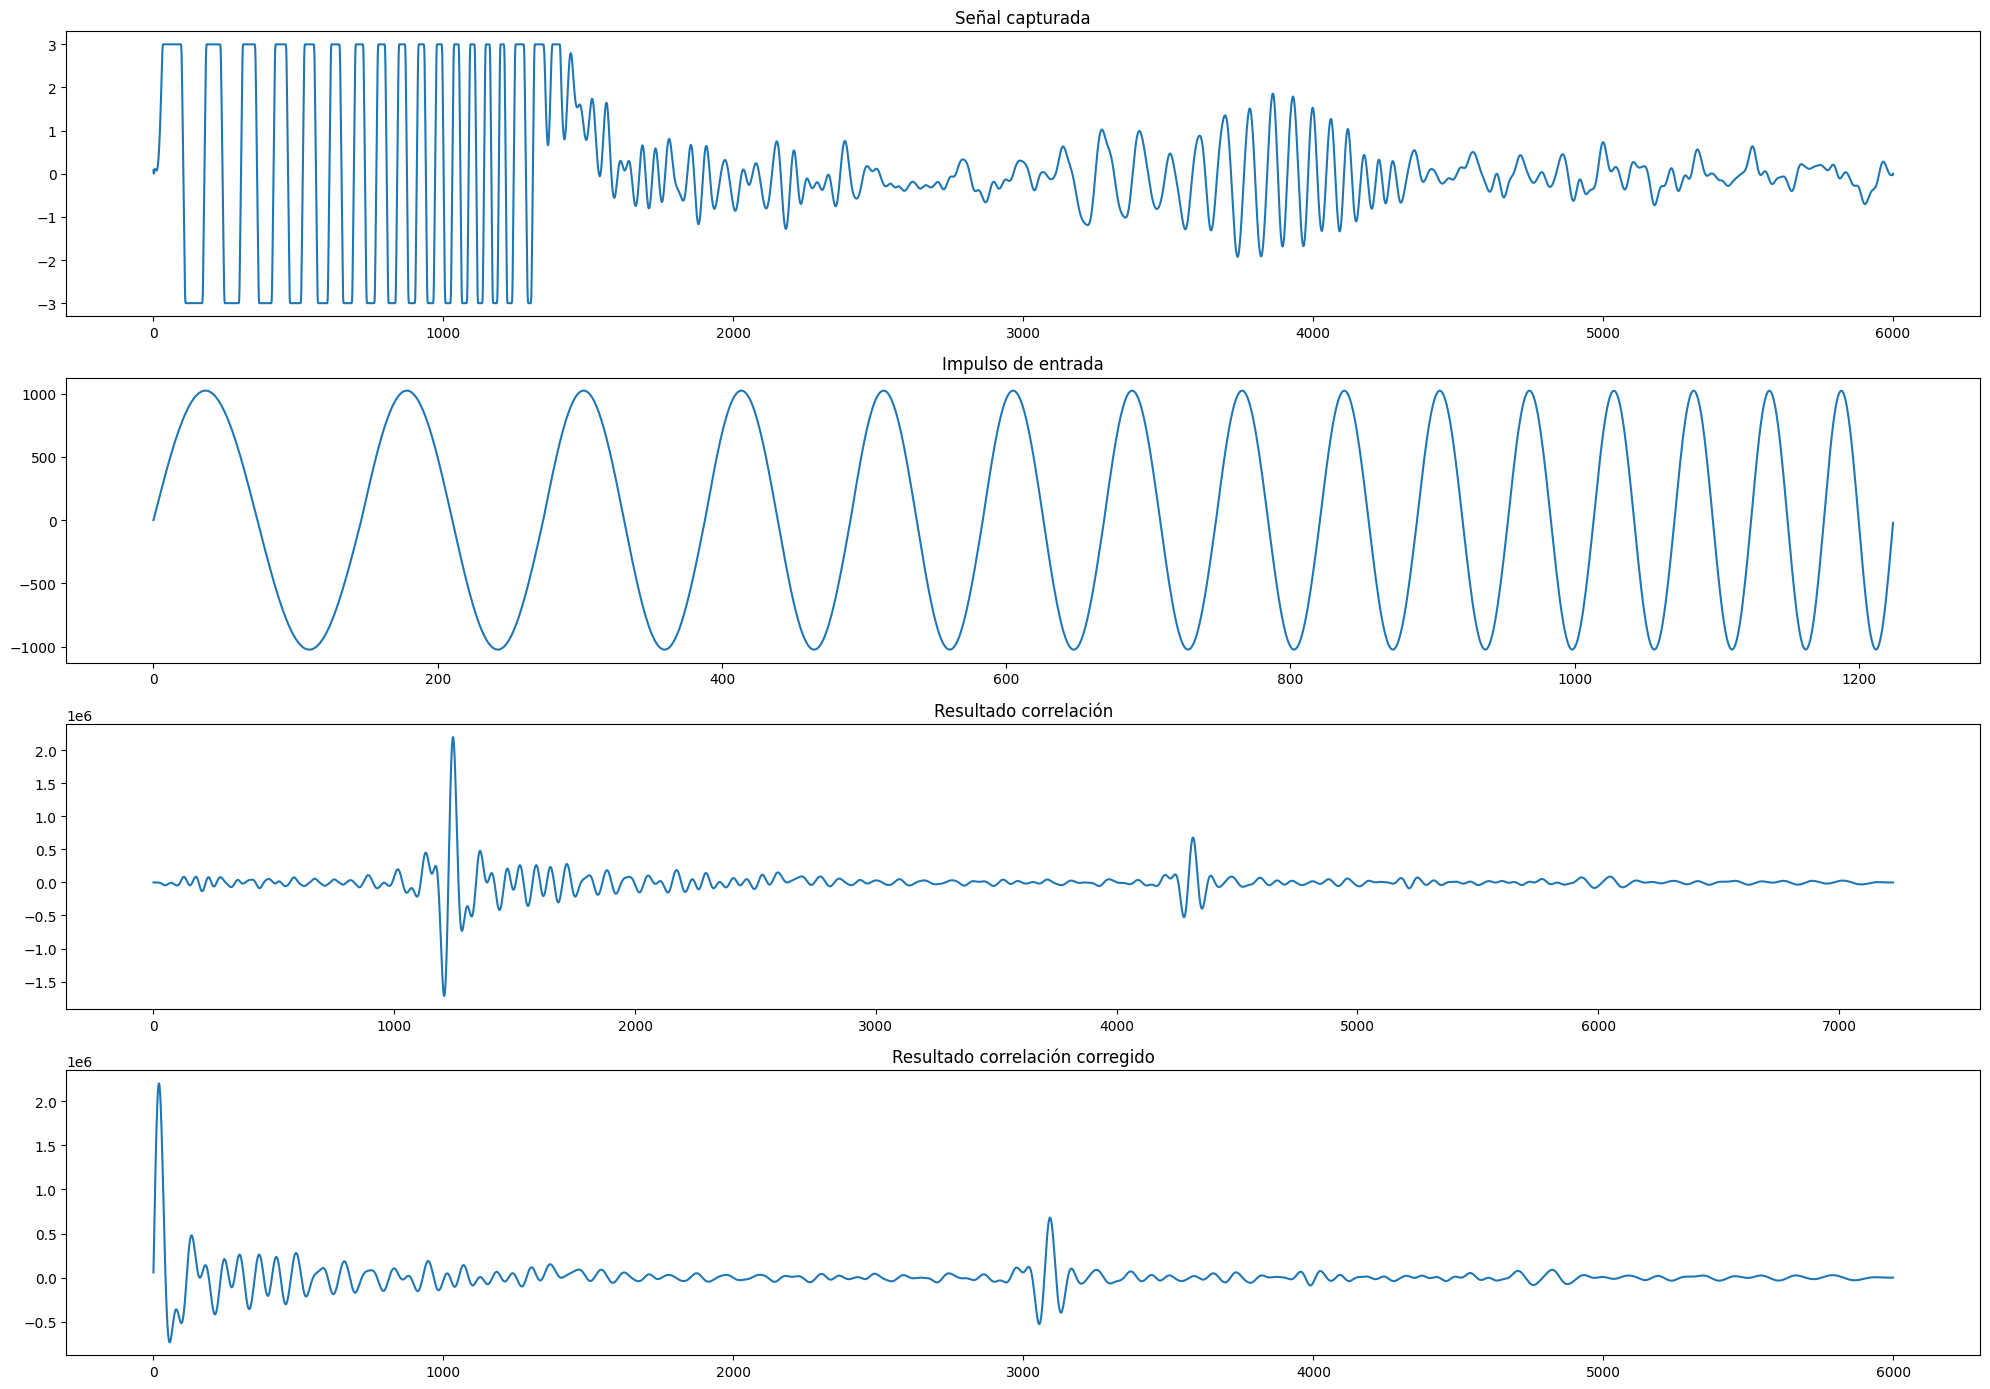

Índice del valor más grande:  3092
Tiempo estimado de recorrido de la señal:  1.7022623655913978
Profundidad estimada: 675.798159139785


In [33]:
id_equipo = 5
path = '_10_23_00_02_36__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)'
full_path = f'../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/{id_equipo}/{path}/'

get_values_for_path(full_path)

Valor de verdad para el pozo 5 el 30/6/22: 467 gas, 1122 niveles.

Número de ecometrias: 3


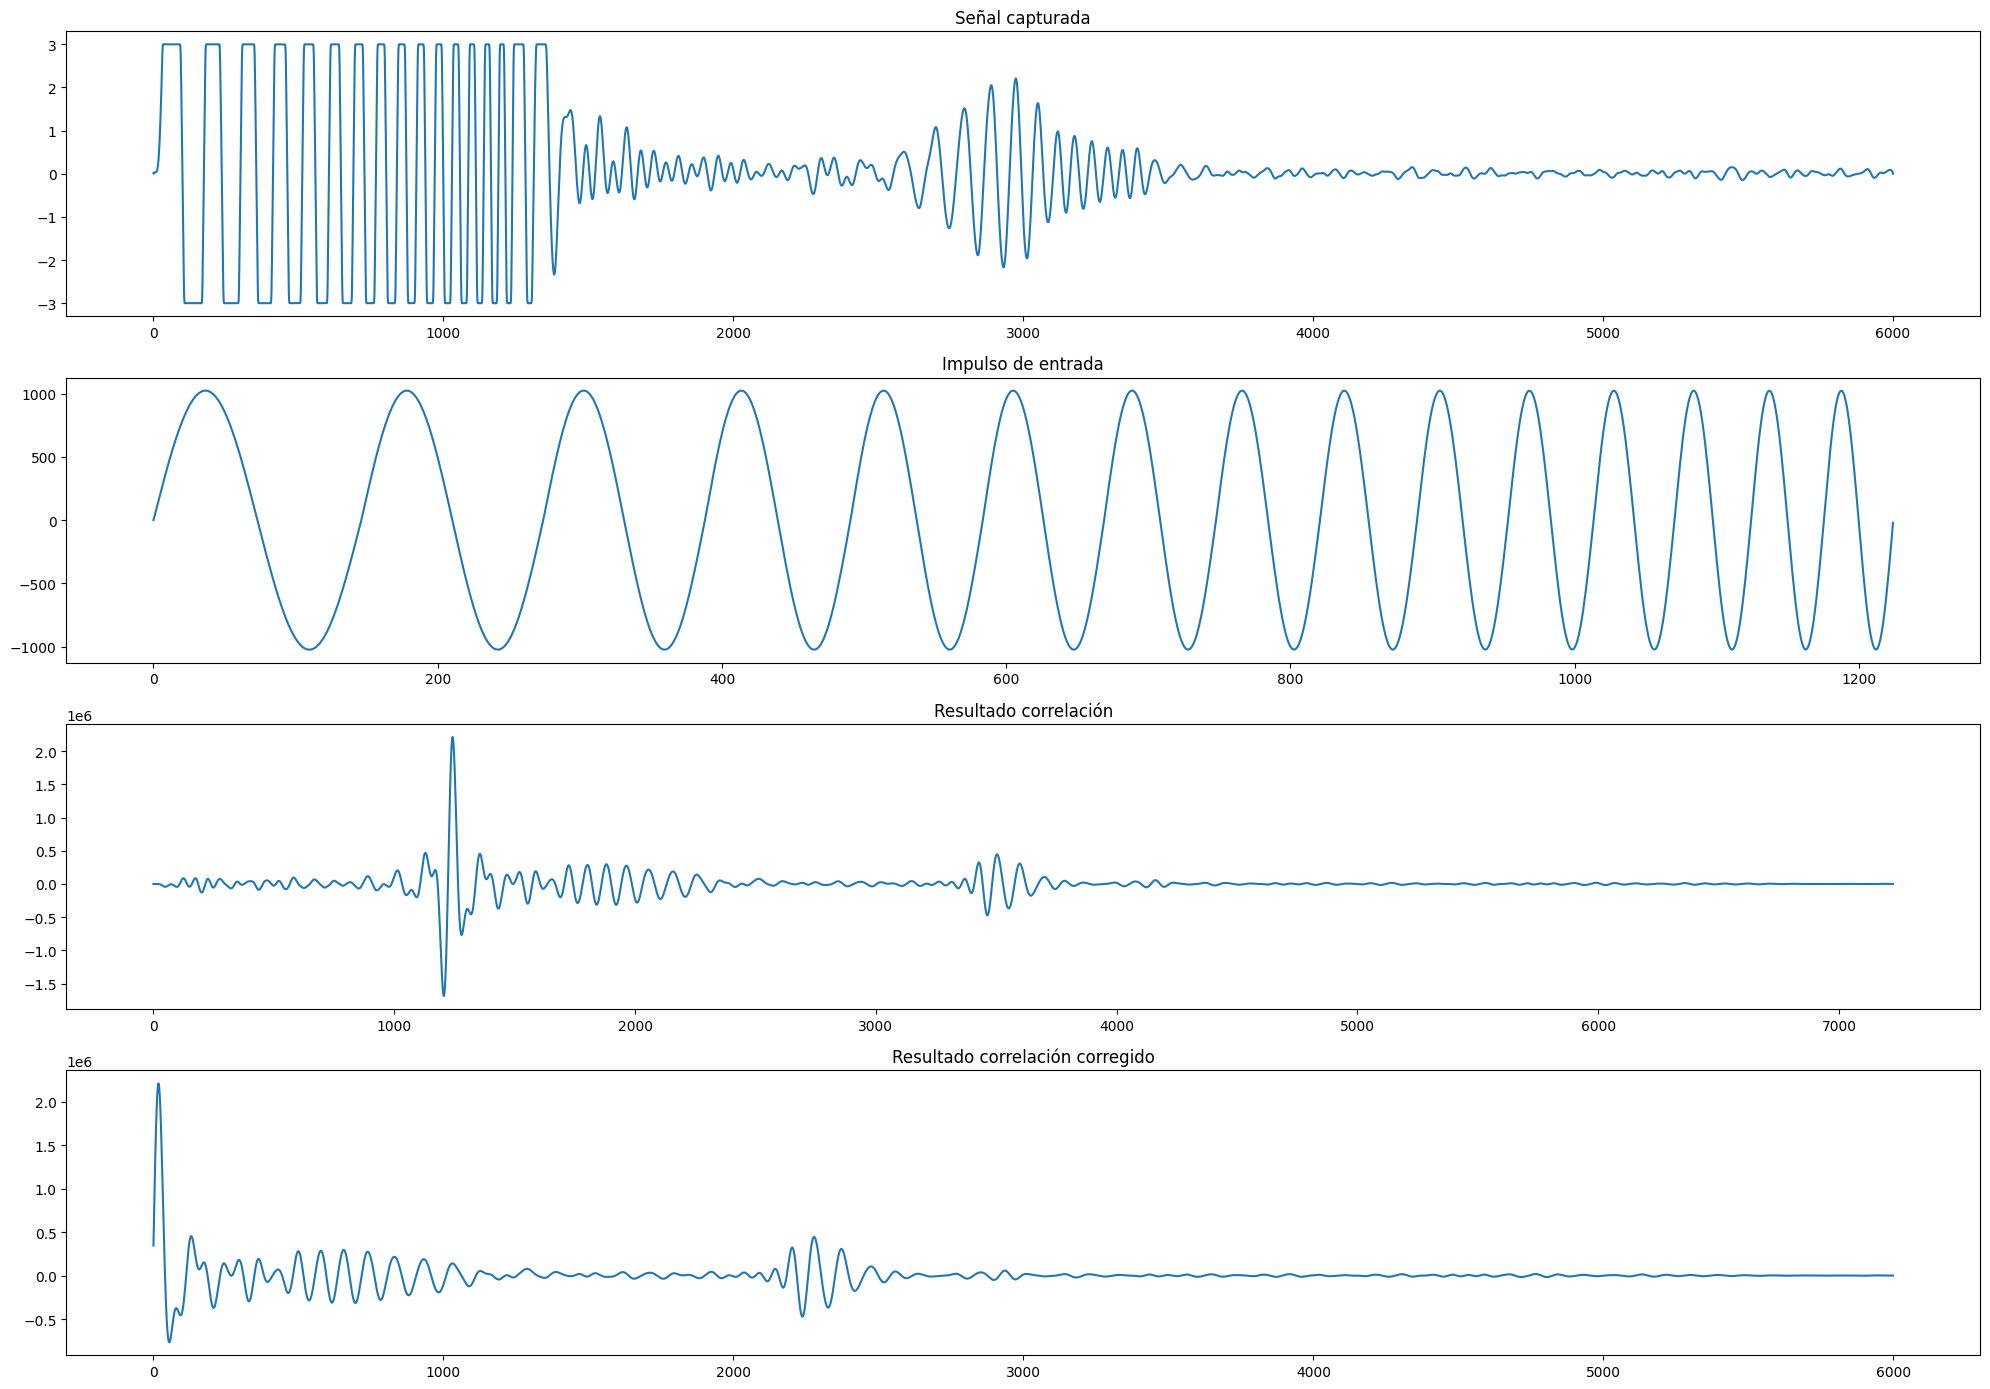

Índice del valor más grande:  2278
Tiempo estimado de recorrido de la señal:  1.2541247311827957
Profundidad estimada: 497.88751827956986


In [34]:
id_equipo = 1
path = '_10_23_00_01_15__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)'
full_path = f'../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/{id_equipo}/{path}/'

get_values_for_path(full_path)

Número de ecometrias: 4


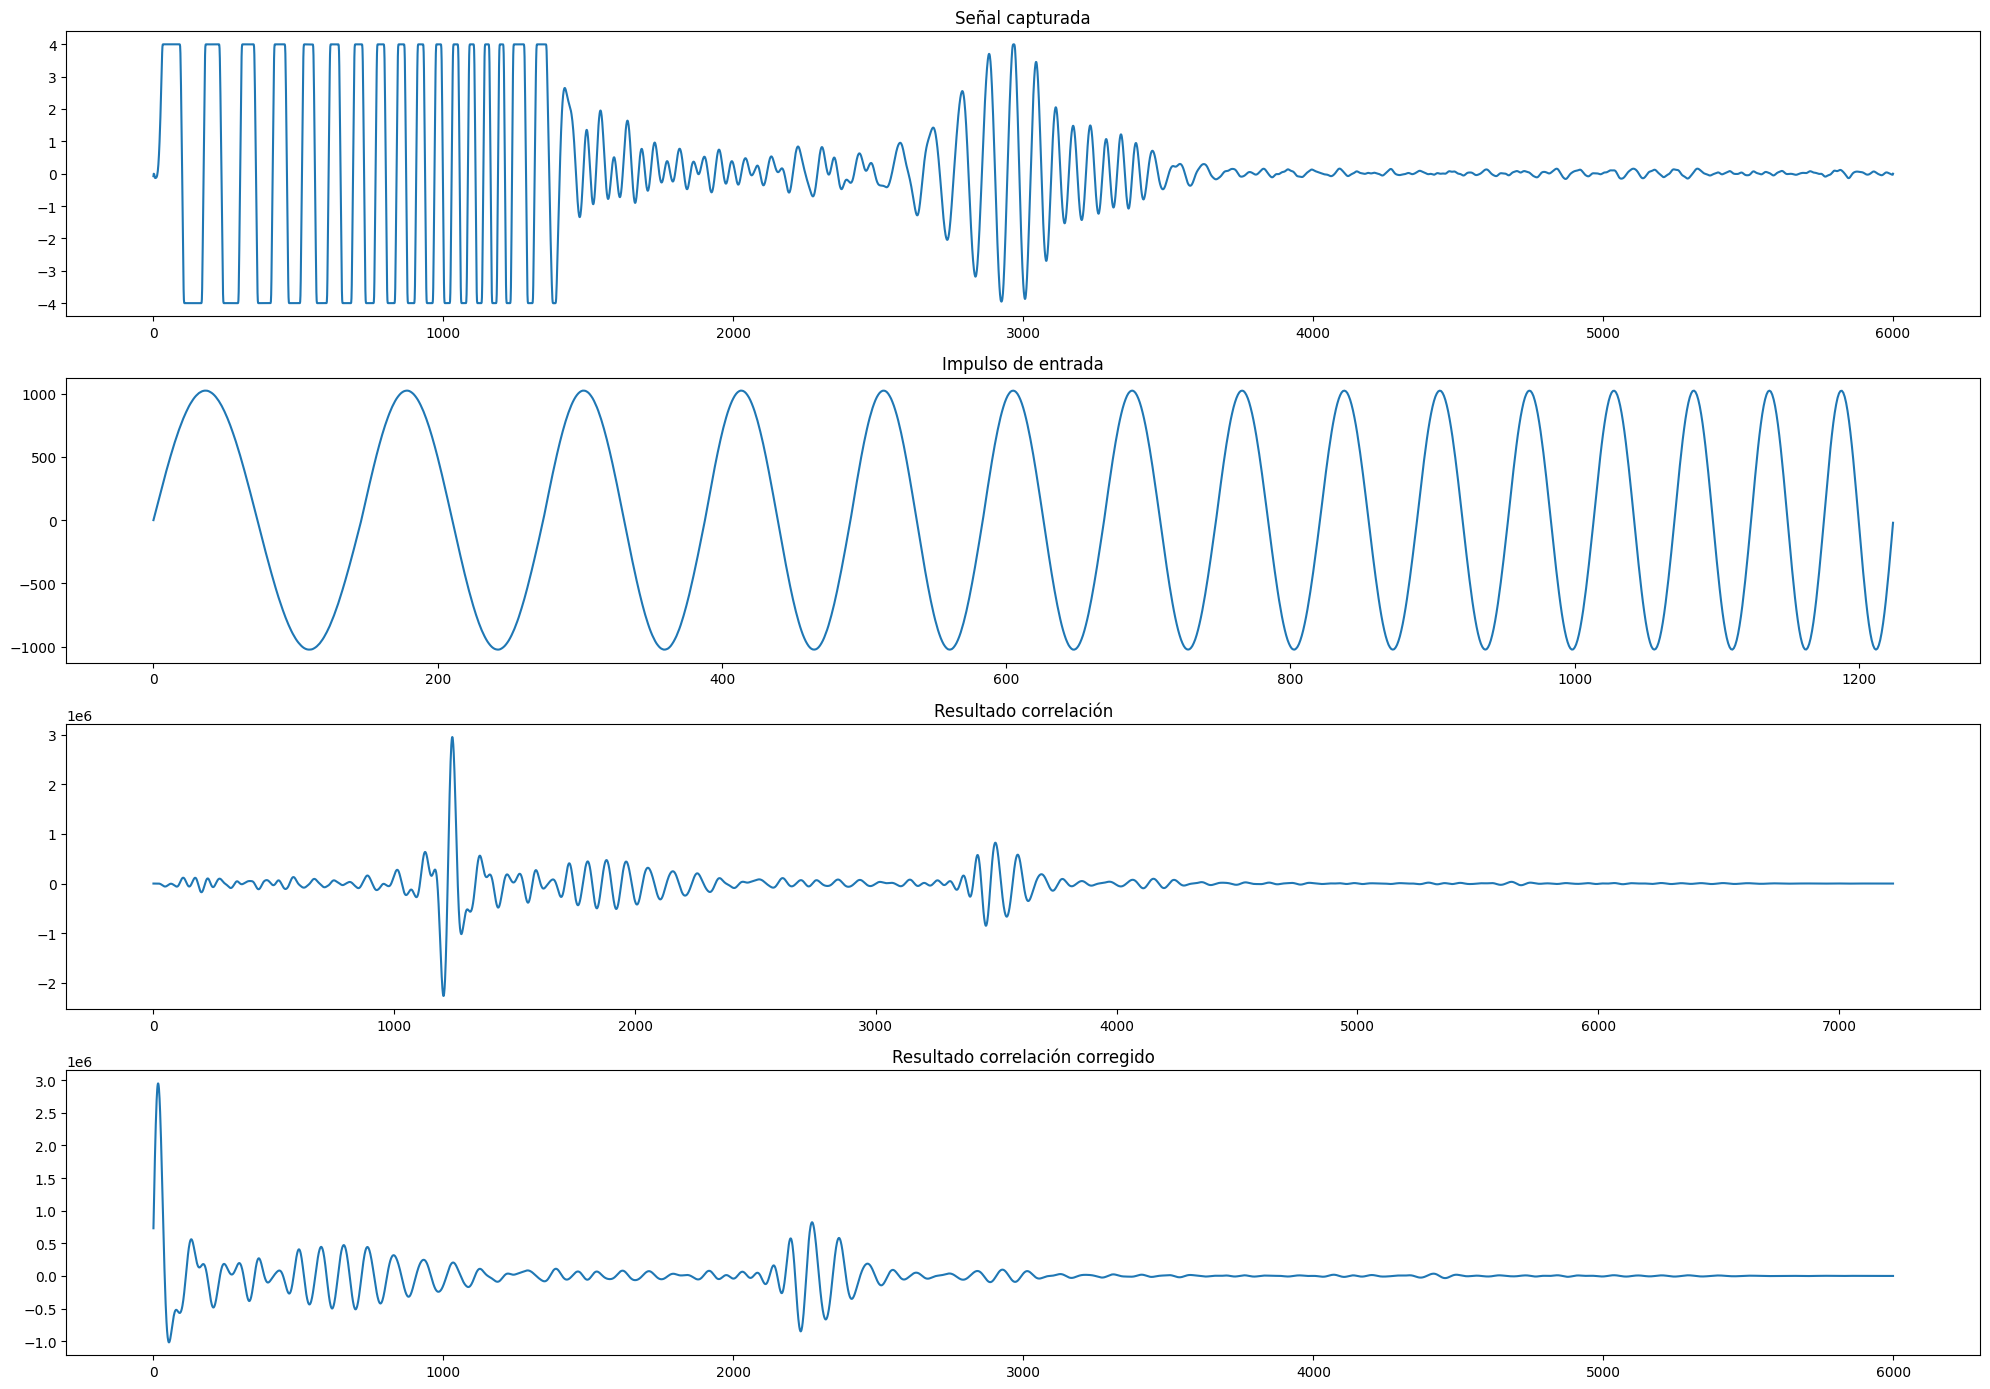

Índice del valor más grande:  2271
Tiempo estimado de recorrido de la señal:  1.2502709677419355
Profundidad estimada: 496.3575741935484


In [35]:
id_equipo = 1
path = '_10_22_20_14_56__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)'
full_path = f'../data/raw/ecometrias/22_10_2021 (prueba cuplas cortas)/{id_equipo}/{path}/'

get_values_for_path(full_path)

Número de ecometrias: 8


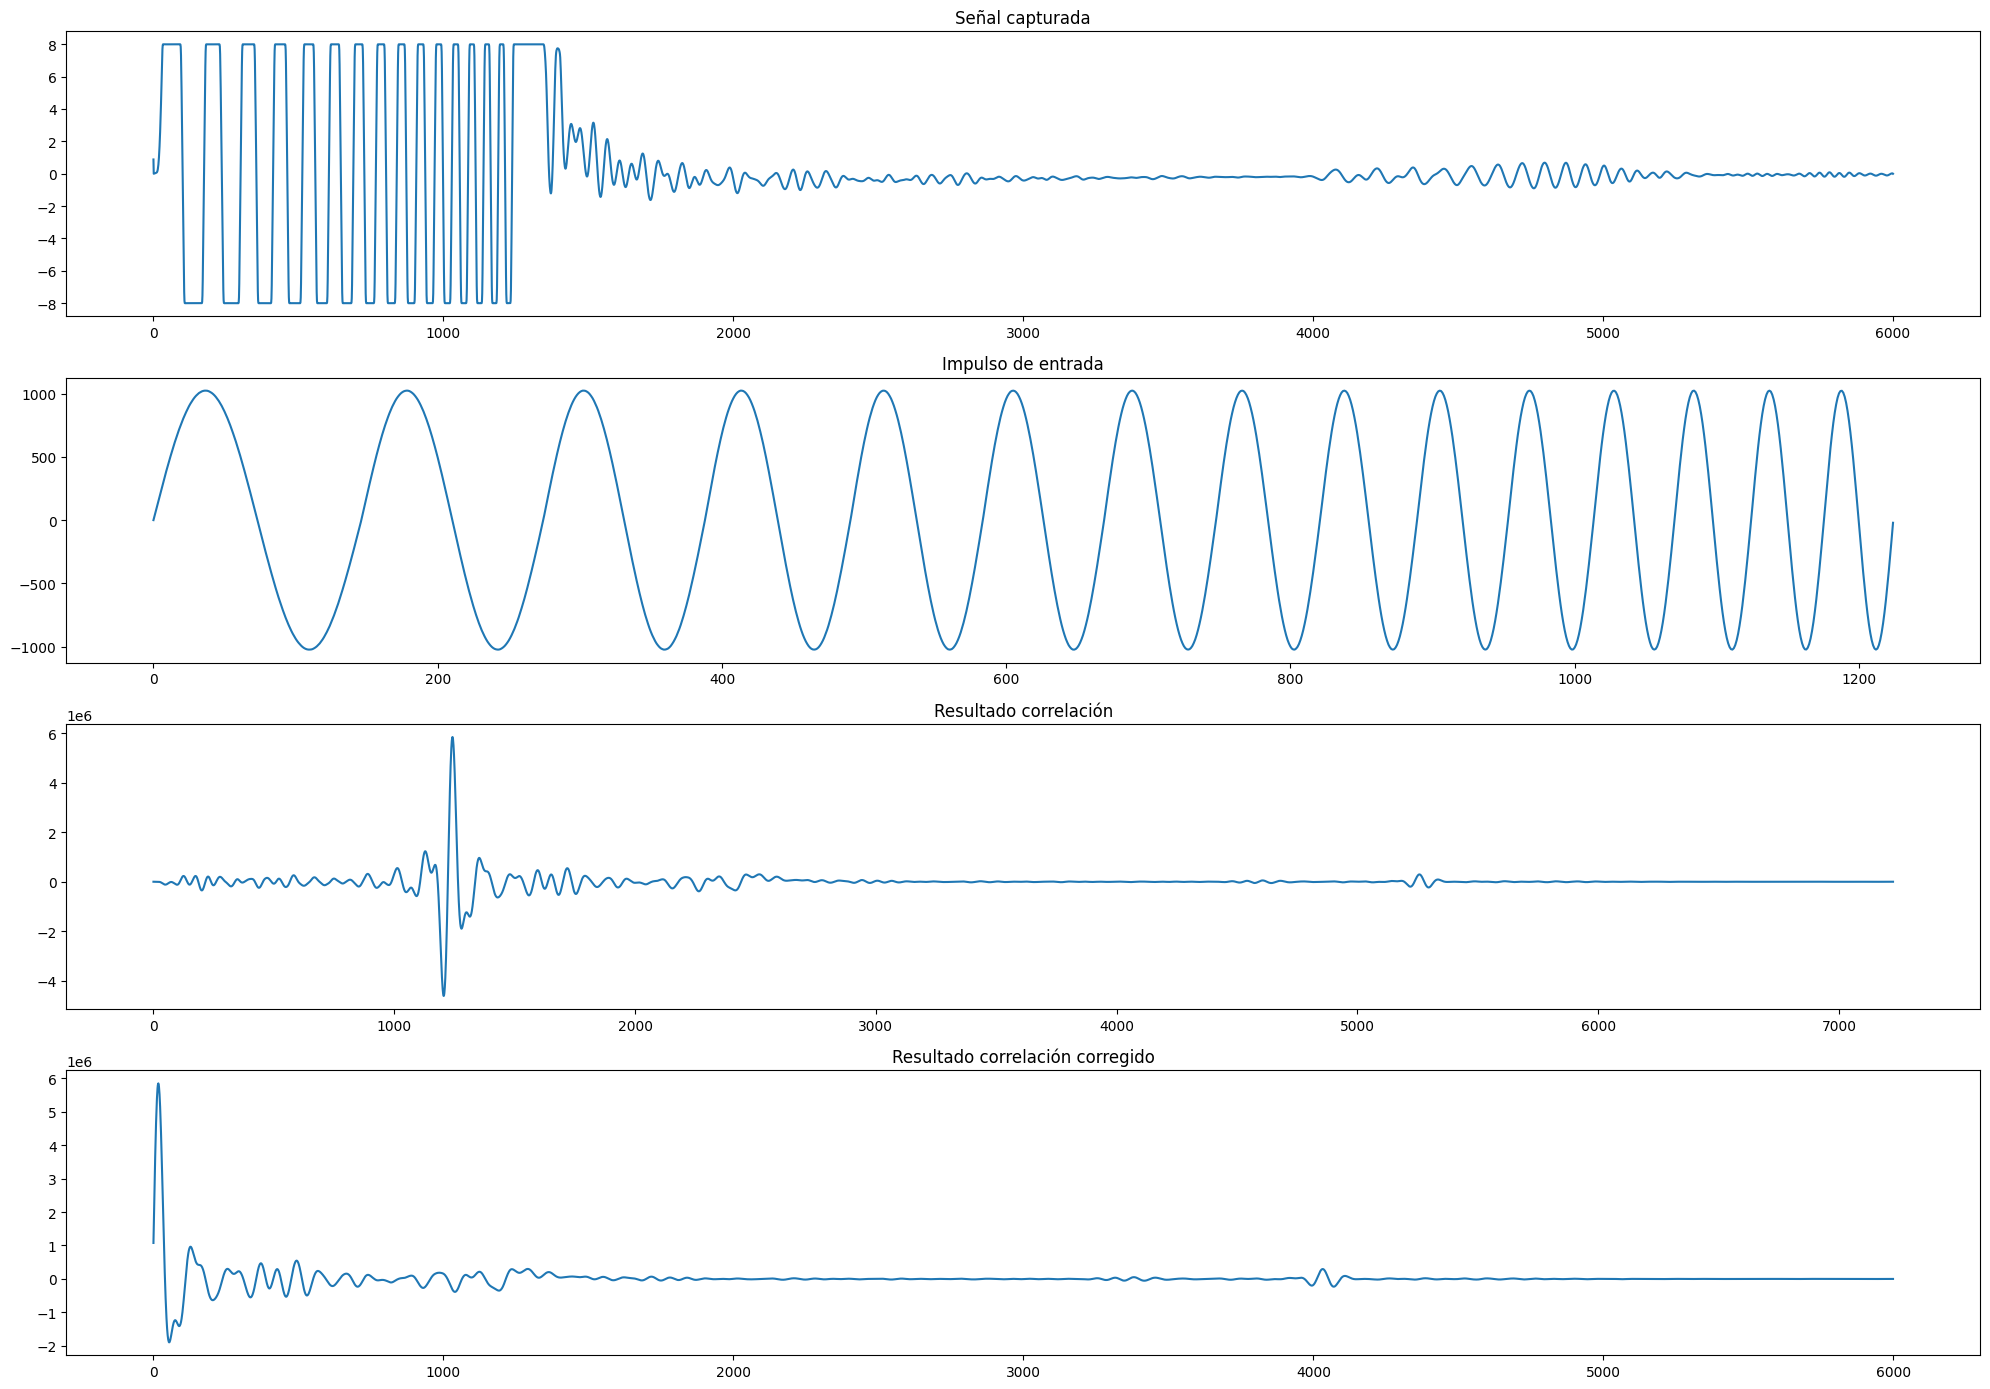

Índice del valor más grande:  4032
Tiempo estimado de recorrido de la señal:  2.2197677419354838
Profundidad estimada: 881.2477935483871


In [36]:
id_equipo = 2
path = '_10_22_20_04_22__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)6000)'
full_path = f'../data/raw/ecometrias/22_10_2021 (prueba cuplas cortas)/{id_equipo}/{path}/'

get_values_for_path(full_path)

Número de ecometrias: 13


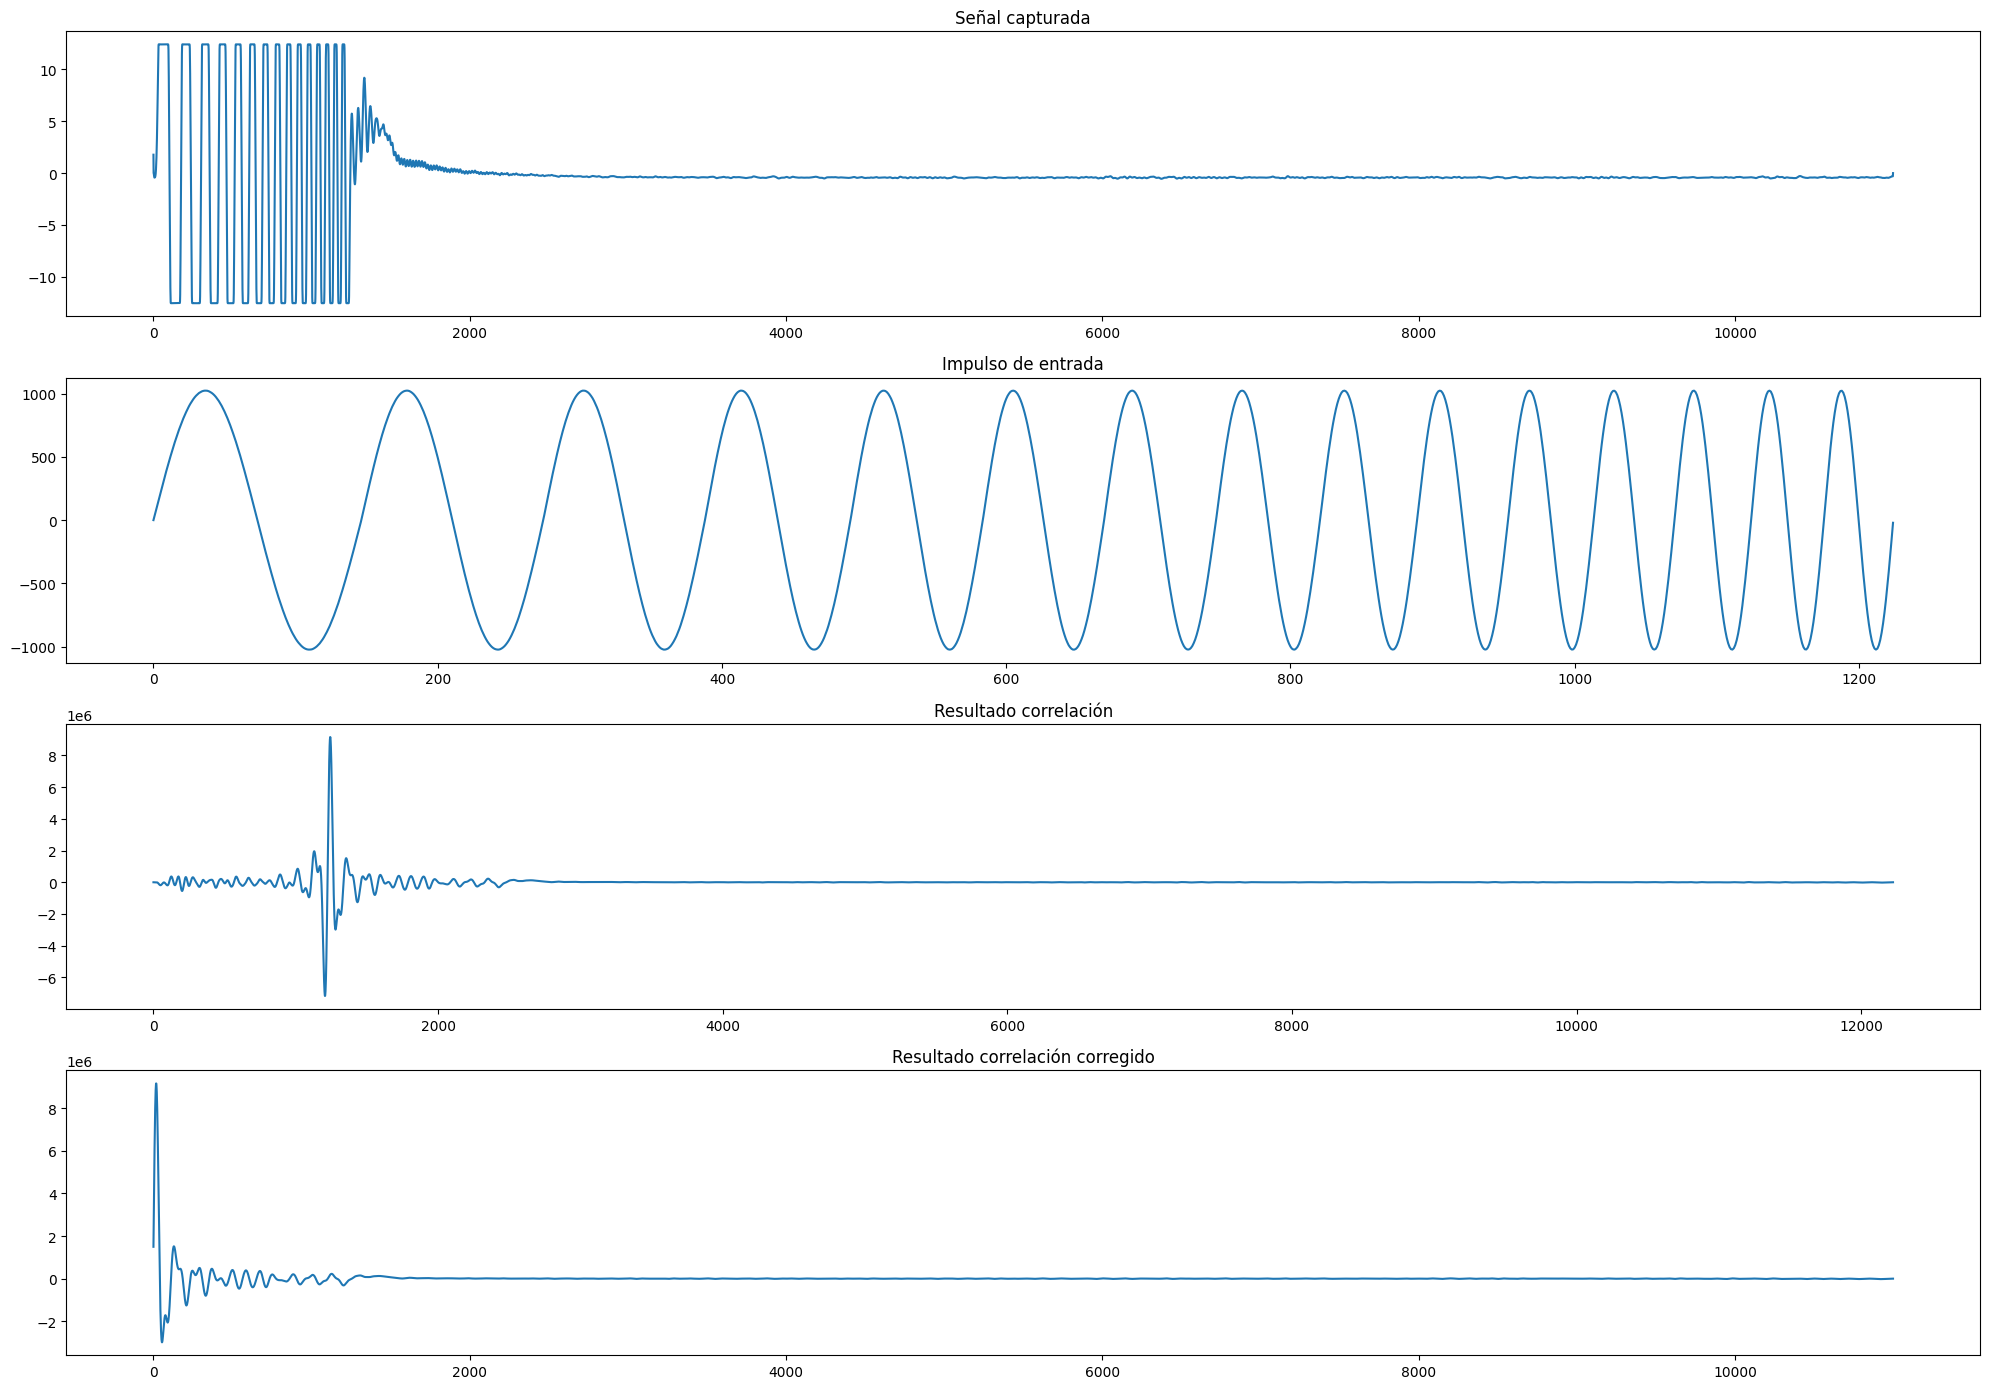

Índice del valor más grande:  2000
Tiempo estimado de recorrido de la señal:  1.1010752688172043
Profundidad estimada: 437.1268817204301


In [37]:
id_equipo = 9
path = '_10_22_21_55_32__Frec1(7)_IncF(1)_Nciclos(15)_SwIn(1)_Down(1024)_Nsamp)11000)'
full_path = f'../data/raw/ecometrias/22_10_2021 (prueba cuplas cortas)/{id_equipo}/{path}/'

get_values_for_path(full_path)

Valor real para este pozo al 23/09/2021: 741 gas, 948 niveles. Estas ecometrías son las que en el informe se detalle que fueron erróneas.

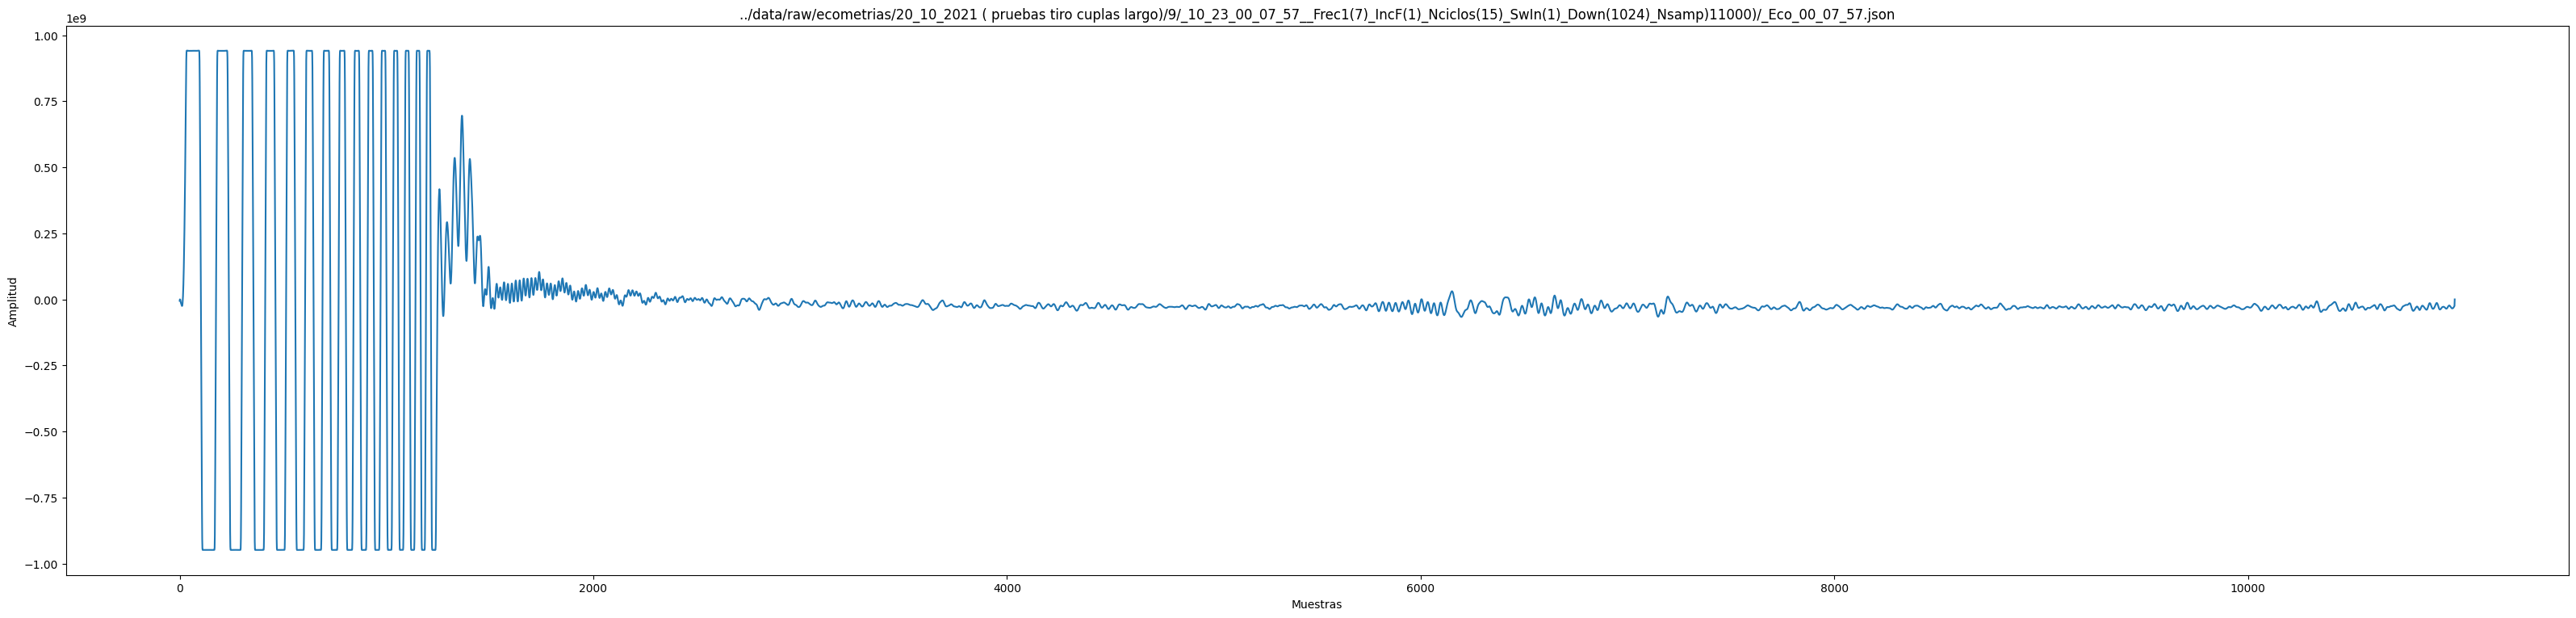

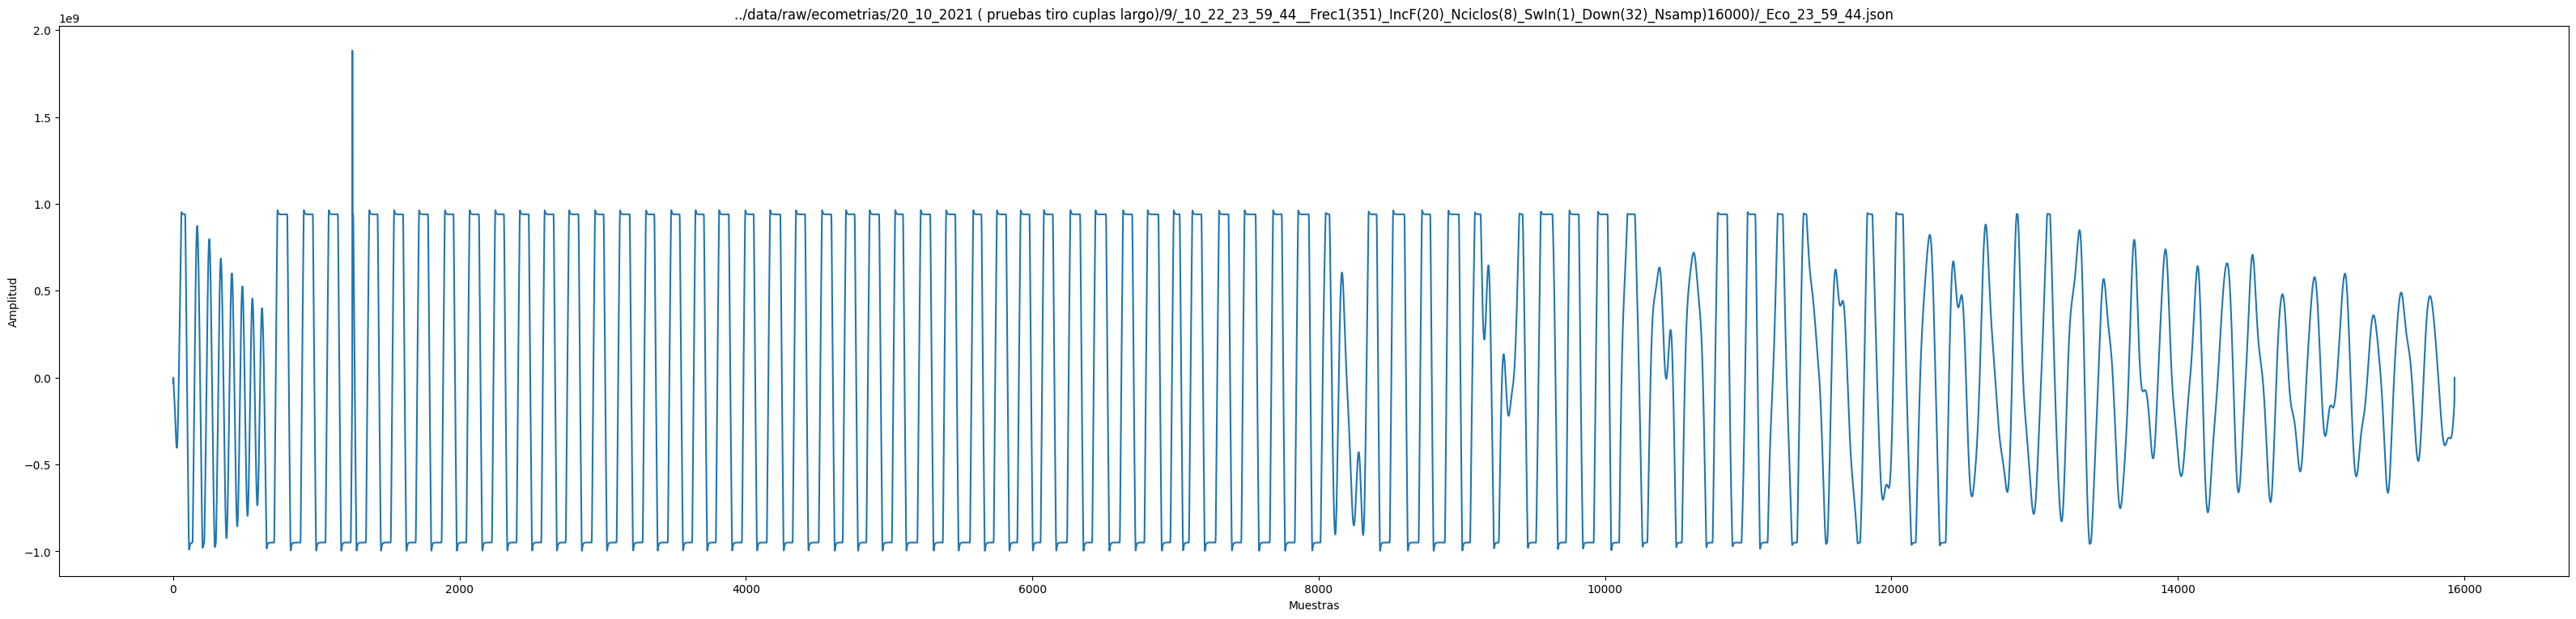

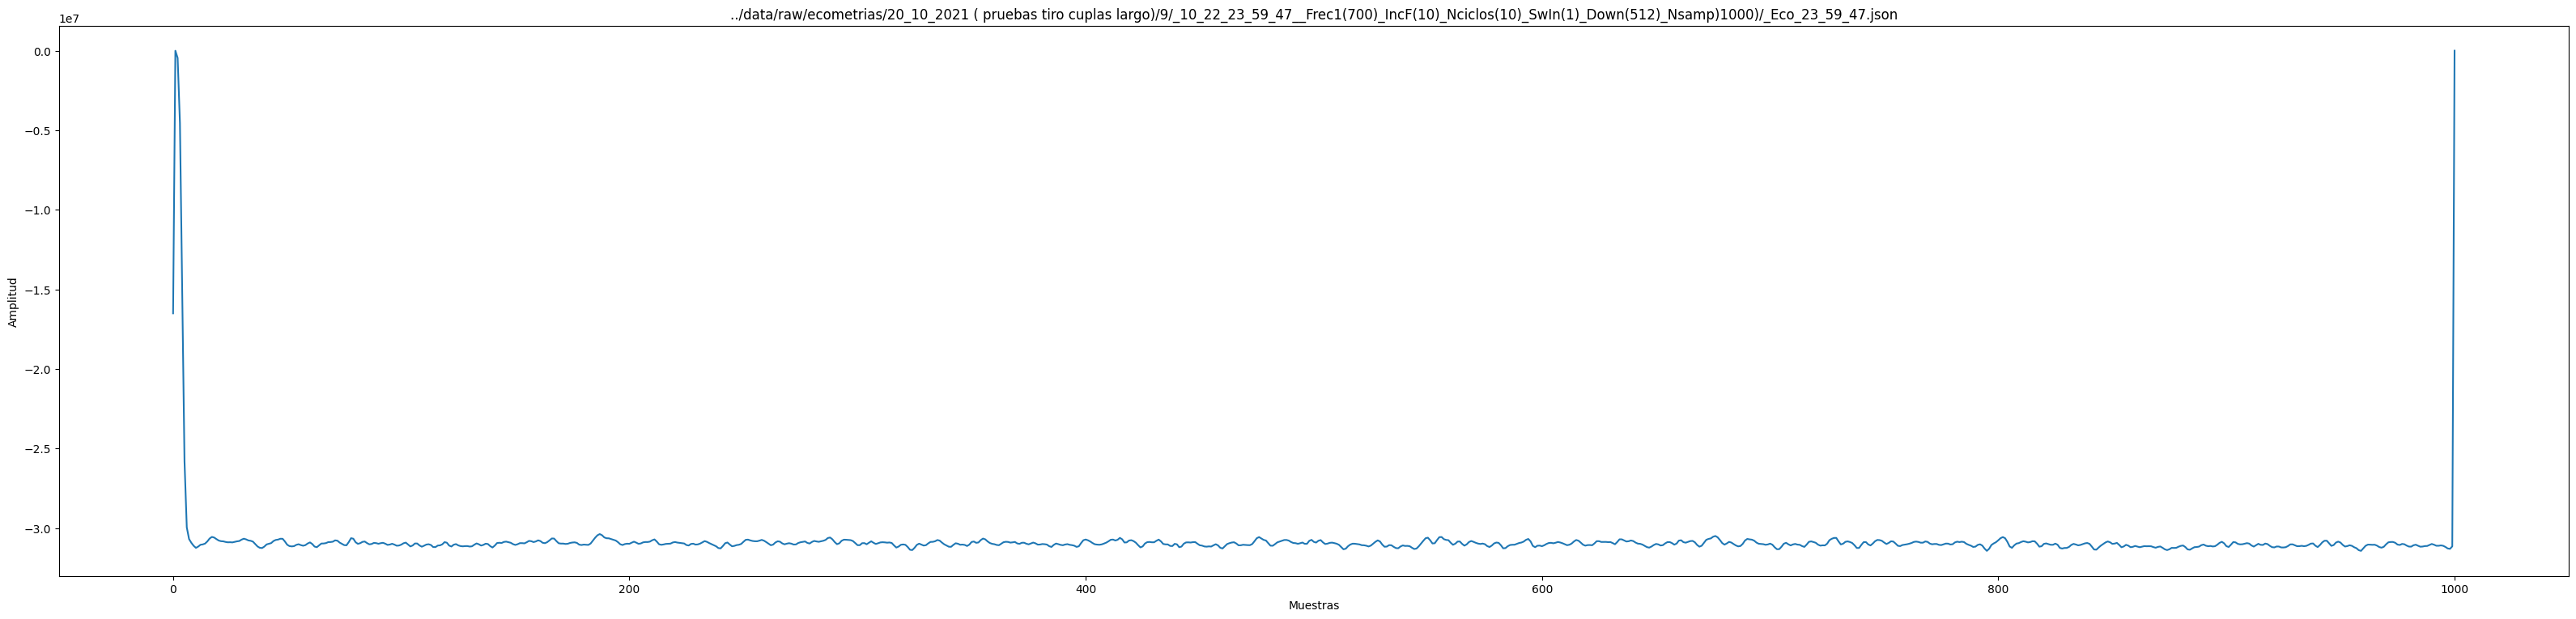

In [38]:
dirs = glob(f'../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/{id_equipo}/*')

for d in dirs:
    if d.split('/')[-1][0] == '_':
        ecometrias = glob(d + '/*.json')
        for e in ecometrias:
            df, final_values = load_sample_file(e)
            
            final_signal_freq = 930000 / df.Down
            # x_values = np.linspace(0, len(final_values) / final_signal_freq, len(final_values))

            # Graficar señal
            fig, ax = plt.subplots(figsize=(40, 10))
            fig.subplots_adjust(bottom=0.2)
            # ax.set_xlim([0, x_values[-1]]) # establecer límites del eje x
            ax.plot(final_values) # agregar datos a la gráfica
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.title(e)
            plt.show()

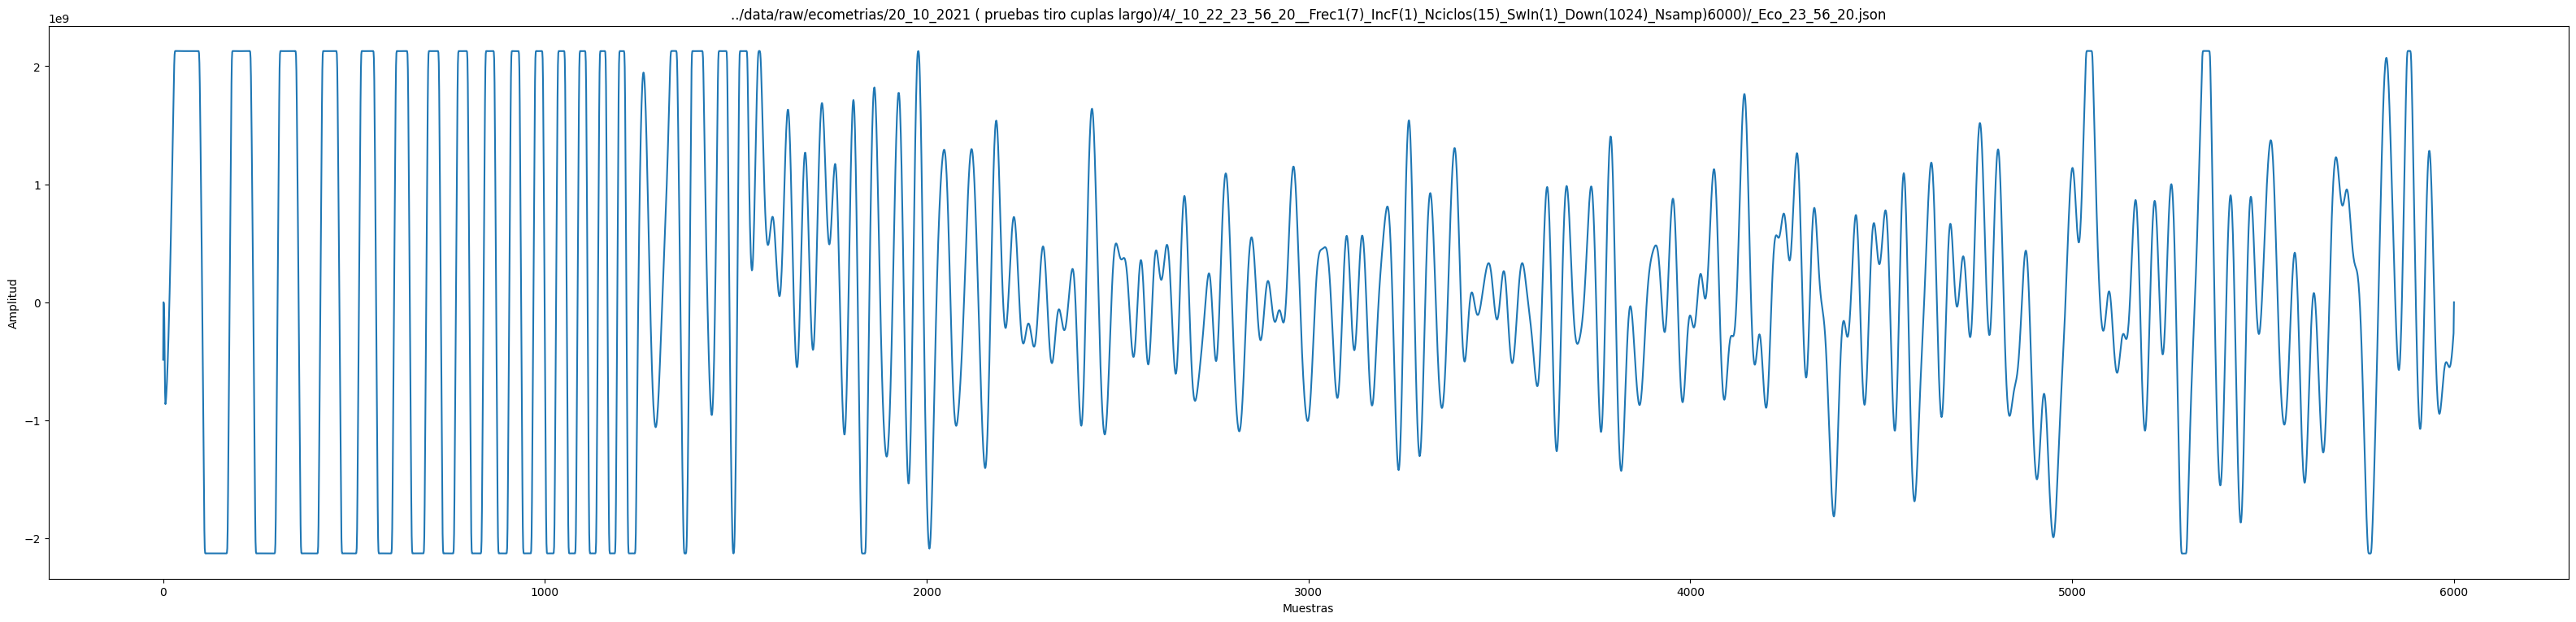

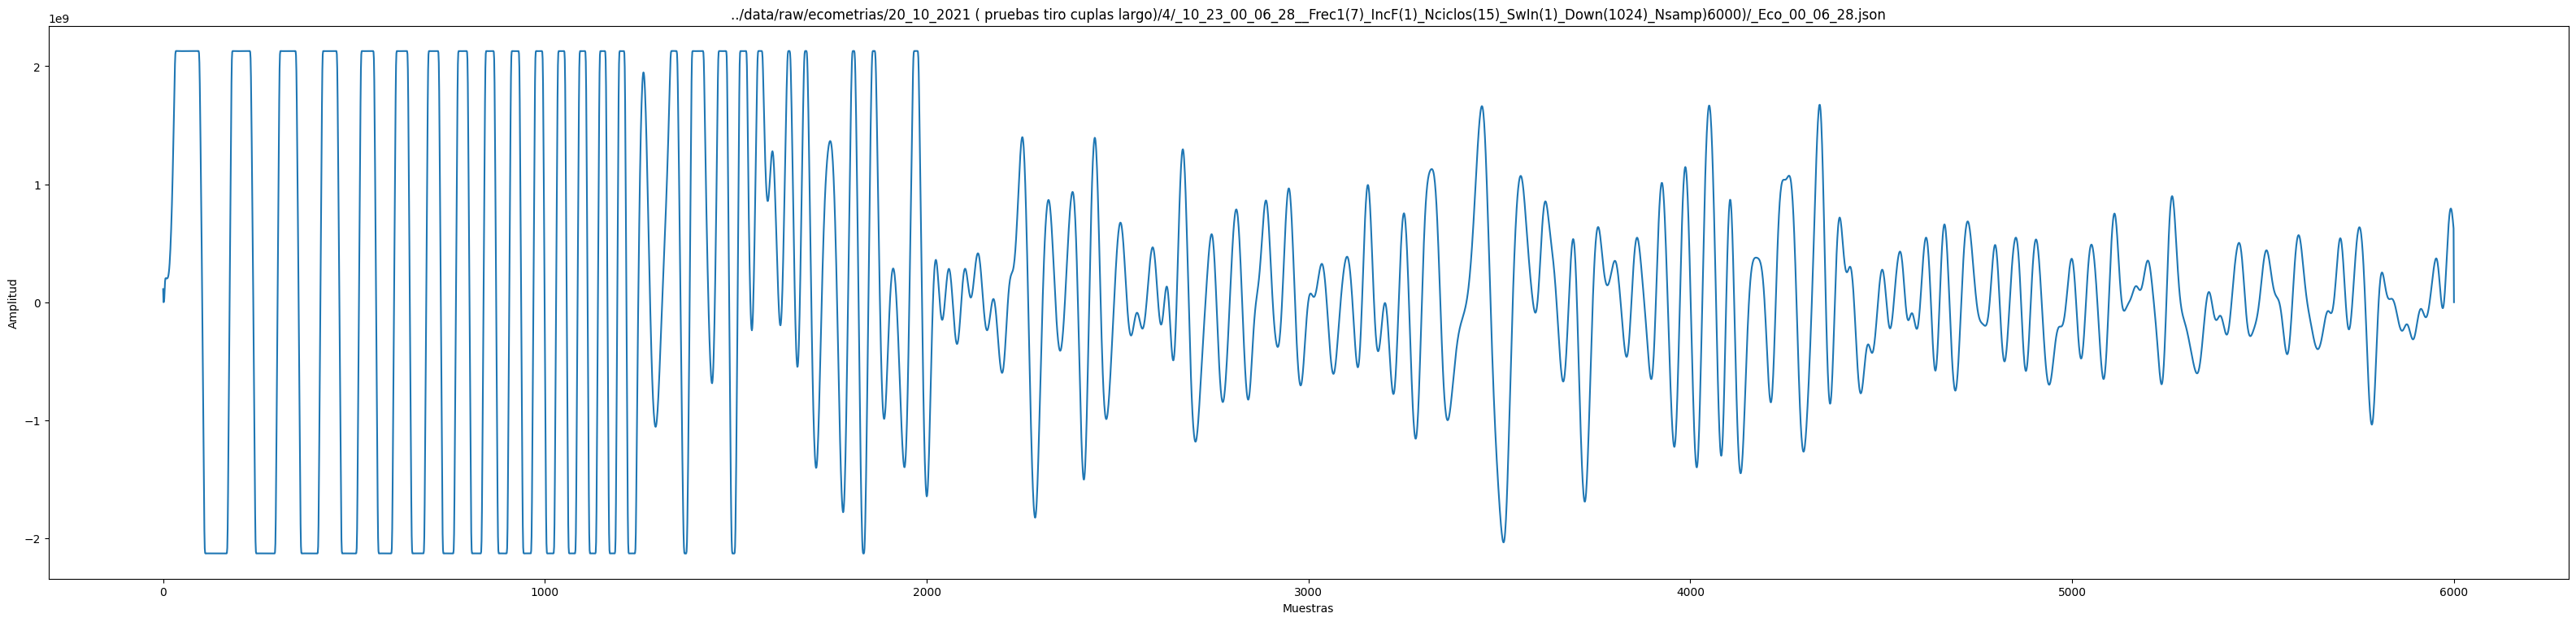

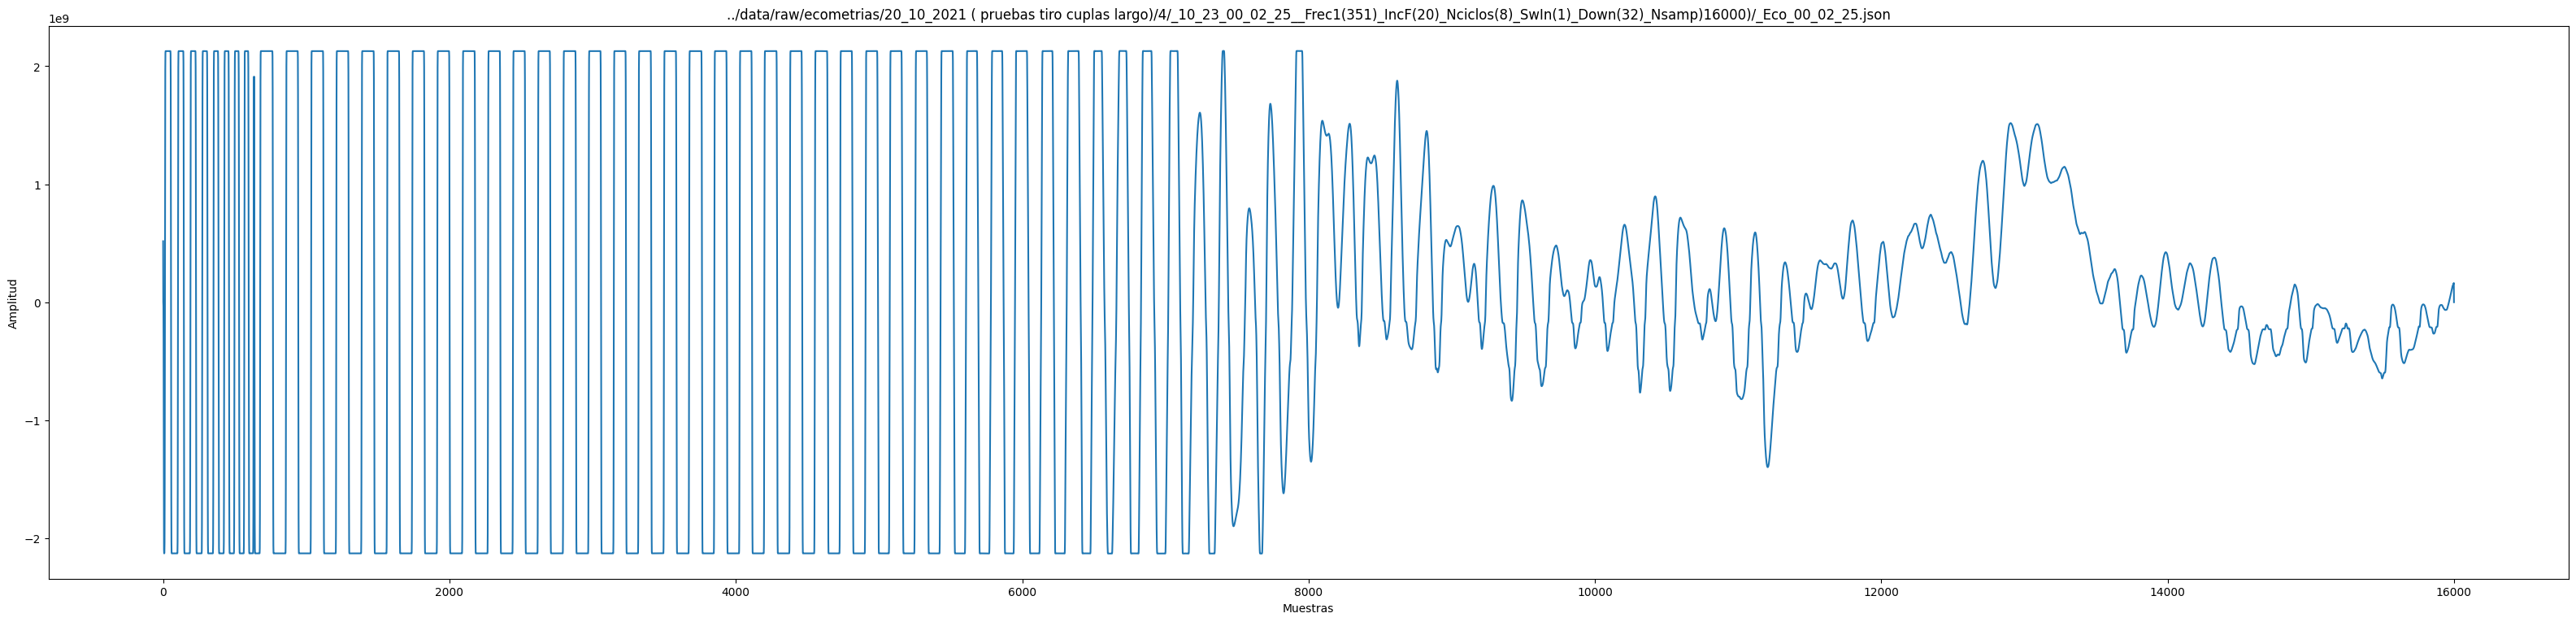

In [39]:
dirs = glob(f'../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/4/*')

for d in dirs:
    if d.split('/')[-1][0] == '_':
        ecometrias = glob(d + '/*.json')
        for e in ecometrias:
            df, final_values = load_sample_file(e)
            
            final_signal_freq = 930000 / df.Down
            # x_values = np.linspace(0, len(final_values) / final_signal_freq, len(final_values))

            # Graficar señal
            fig, ax = plt.subplots(figsize=(40, 10))
            fig.subplots_adjust(bottom=0.2)
            # ax.set_xlim([0, x_values[-1]]) # establecer límites del eje x
            ax.plot(final_values) # agregar datos a la gráfica
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.title(e)
            plt.show()

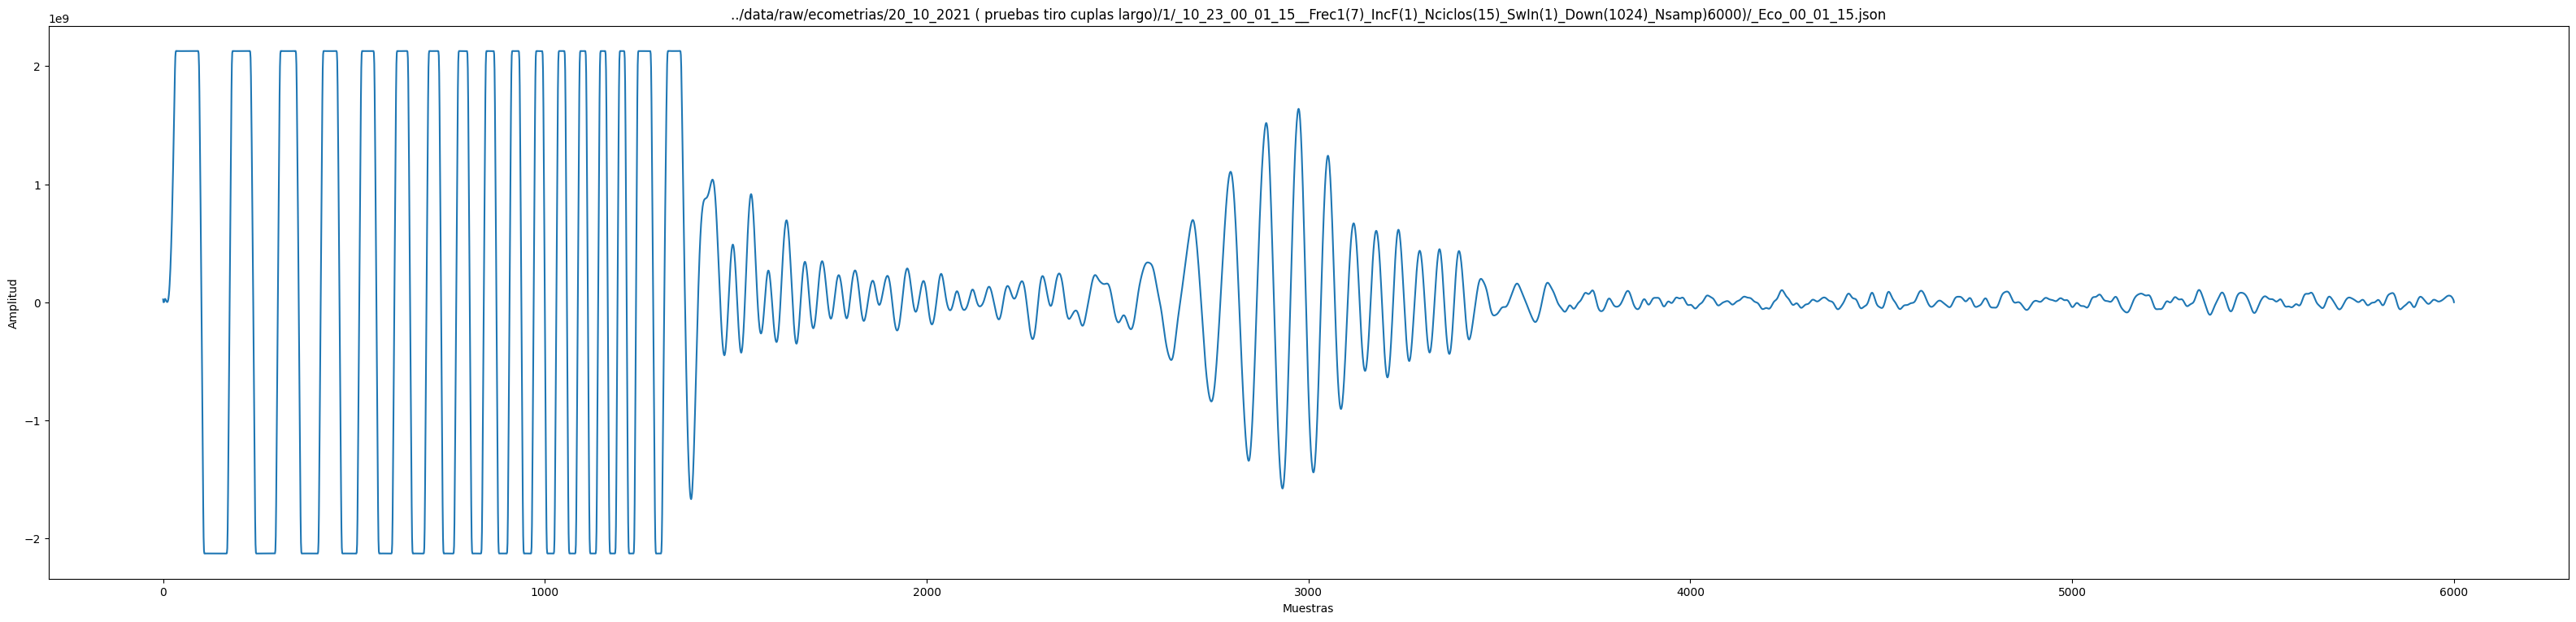

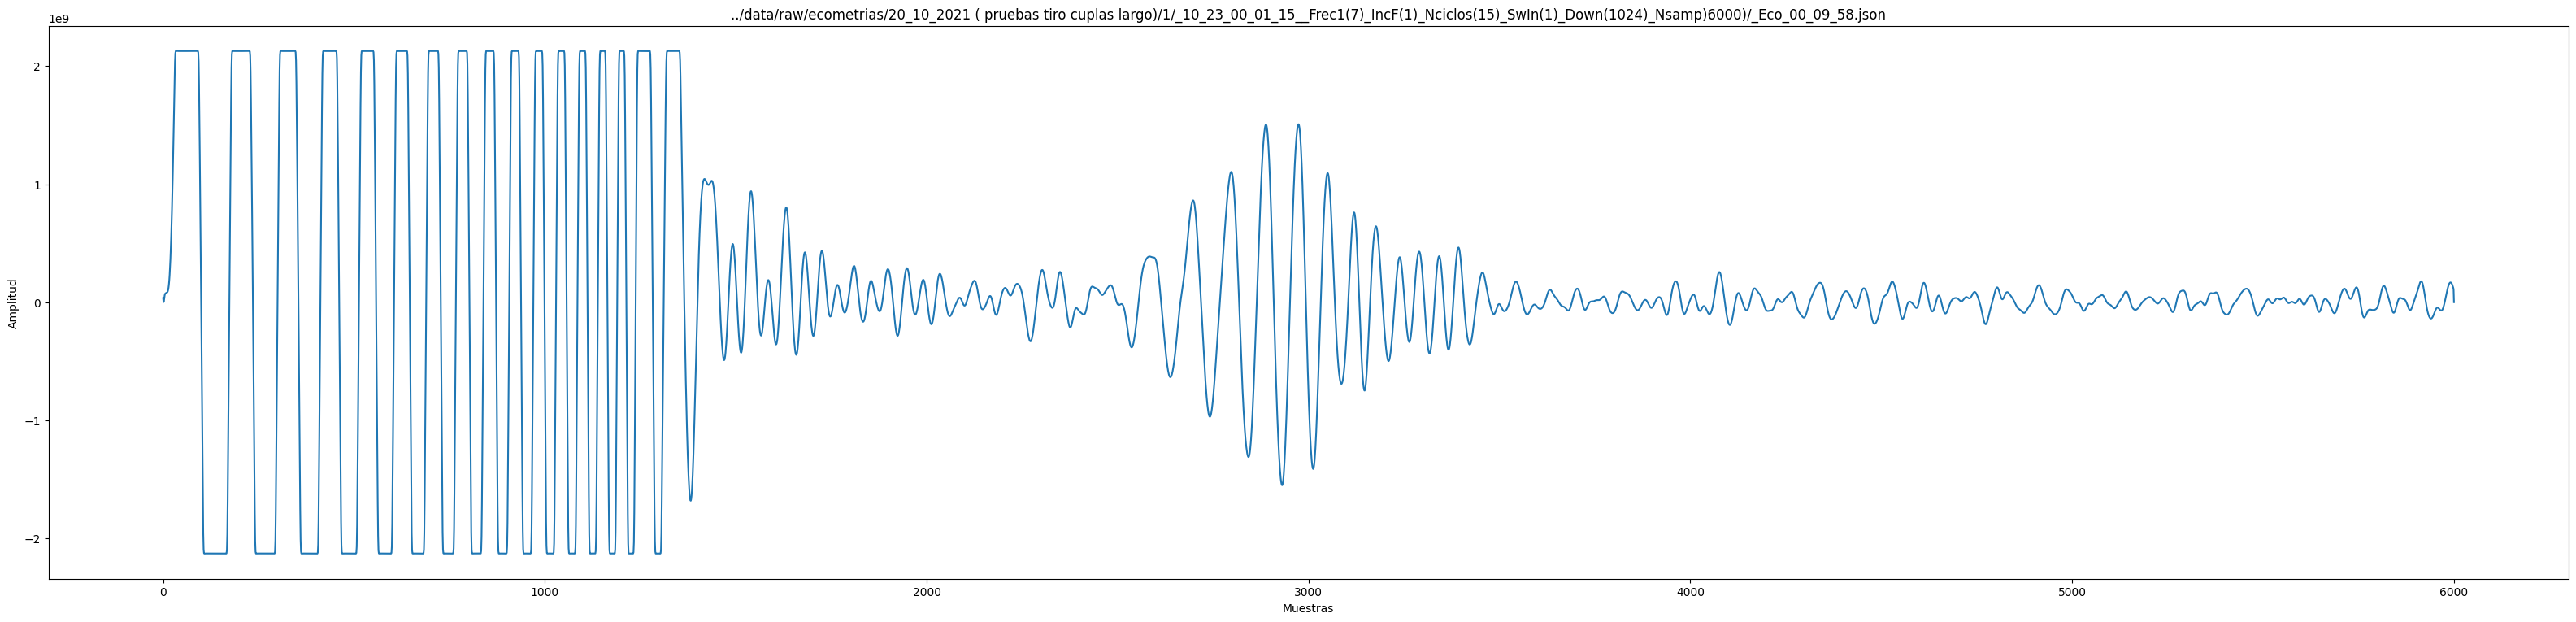

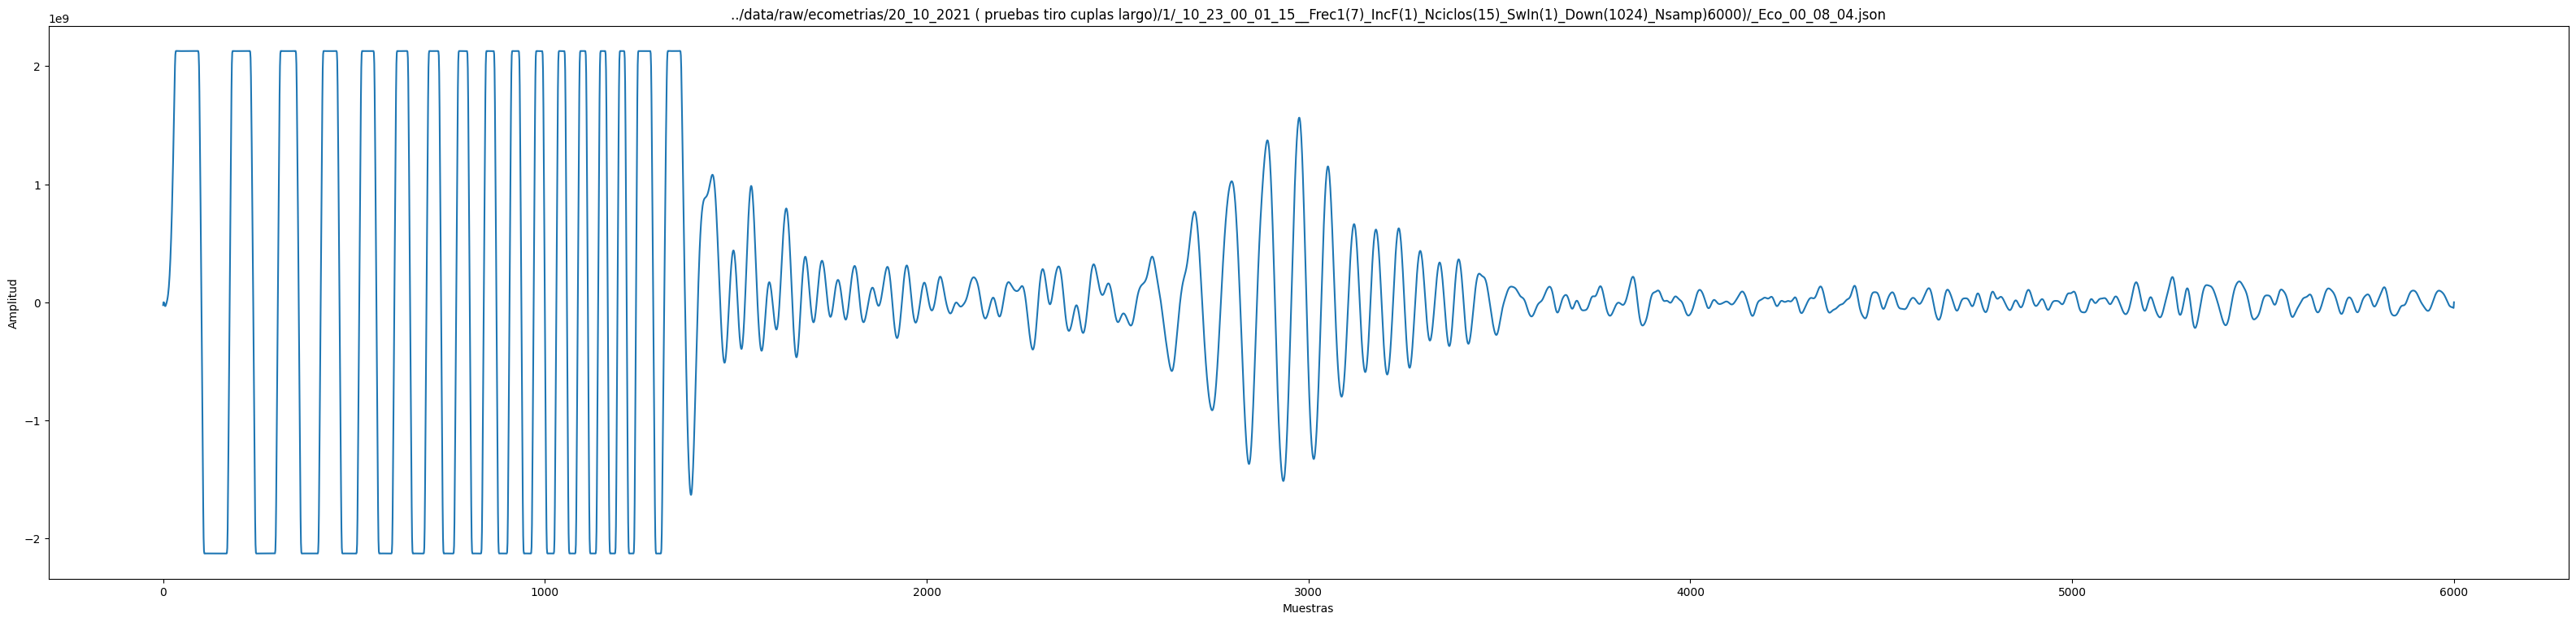

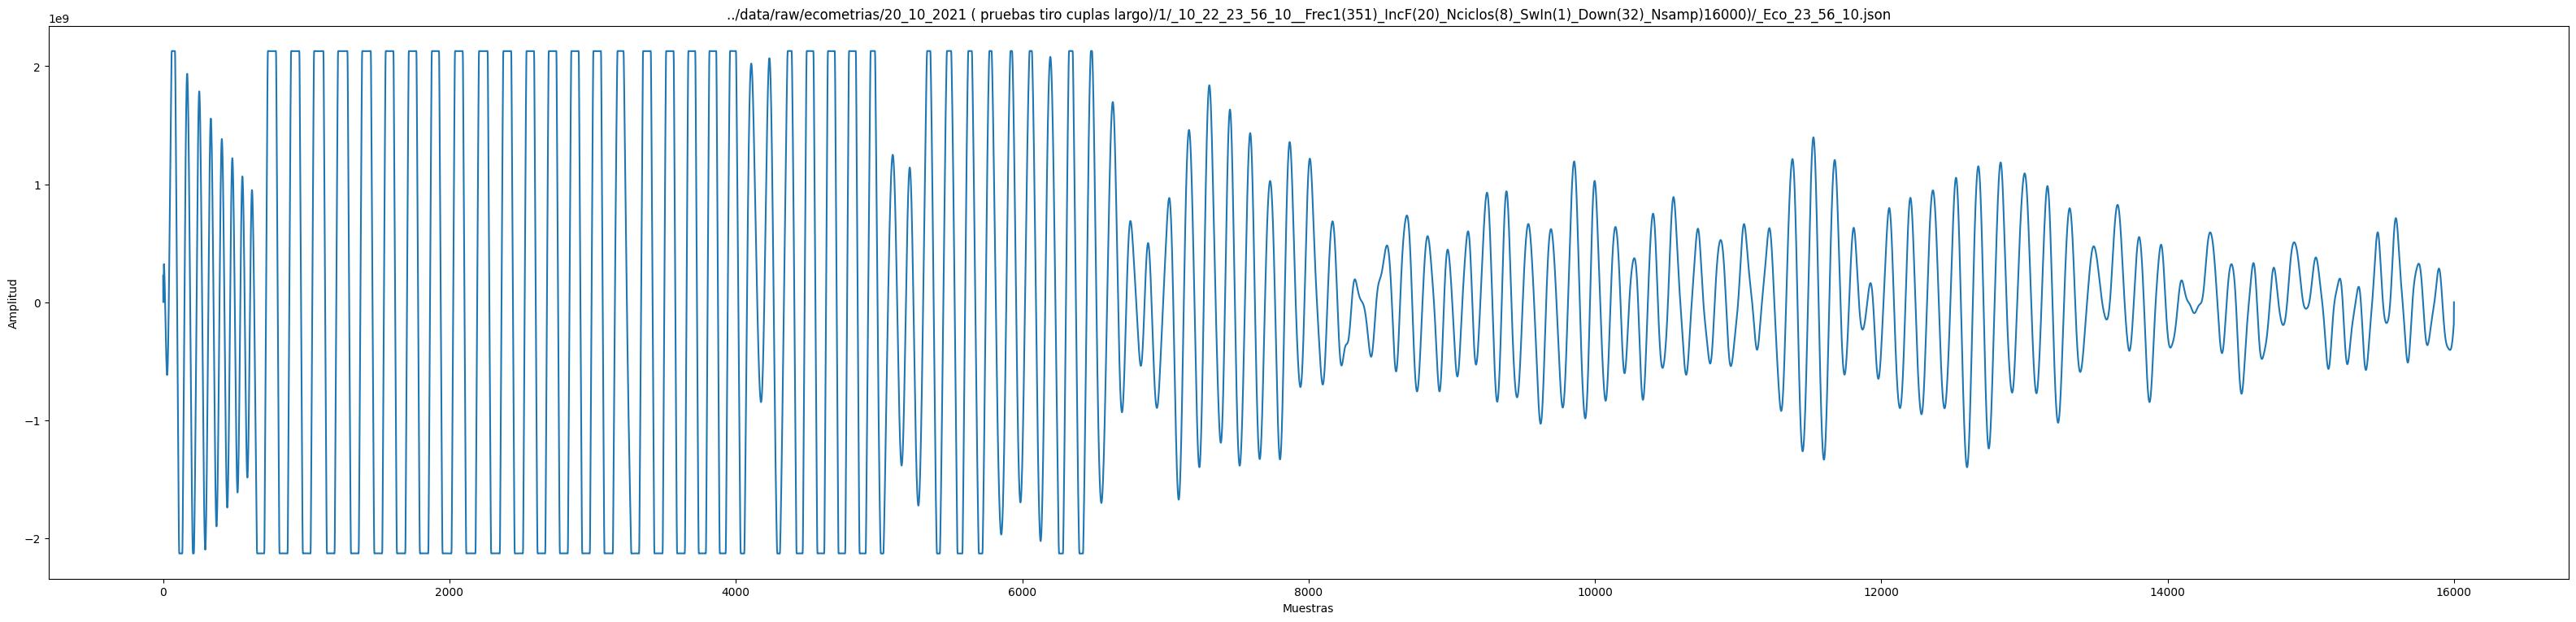

In [40]:
dirs = glob(f'../data/raw/ecometrias/20_10_2021 ( pruebas tiro cuplas largo)/1/*')

for d in dirs:
    if d.split('/')[-1][0] == '_':
        ecometrias = glob(d + '/*.json')
        for e in ecometrias:
            df, final_values = load_sample_file(e)
            
            final_signal_freq = 930000 / df.Down
            # x_values = np.linspace(0, len(final_values) / final_signal_freq, len(final_values))

            # Graficar señal
            fig, ax = plt.subplots(figsize=(40, 10))
            fig.subplots_adjust(bottom=0.2)
            # ax.set_xlim([0, x_values[-1]]) # establecer límites del eje x
            ax.plot(final_values) # agregar datos a la gráfica
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.title(e)
            plt.show()